# **Portfolio Management Project: Implementation in a Multi-Asset Portfolio Allocation**

François Pedeboy (francois.pedeboy@etud.univ-evry.fr) and Youssef Louraoui (20230348@etud.univ-evry.fr)

## **Preparation of the Working Environment on Python**

Below, we detail the essential Python packages that constitute the basis of our portfolio and run a script to check if the required packages for this project are well installed in the Python environment.

- Pandas for data manipulation.
- NumPy for mathematical operations and complex computations with data.
- SciPy in order to perform, for instance, the complex portfolio optimisation frameworks that we will implement in this project.
- Matplotlib, seaborn and ploty for data visualisation.
- Riskfolio-lib as an additional tool to help us compute portfolio strategies.

In [160]:
#Install Riskfolio library for portfolio allocation and optimisation and ploty for data visualisation.
!pip install riskfolio-lib
!pip install plotly==5.19.0

We import the necessary libraries to perform the analysis.

In [161]:
#Install the preliminary packages to run the code
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## **1. Data and Initial Backtest**

Our investment universe is composed of different asset classes. Here's an overview into the assets used in the project:

- G10 Currencies: The portfolio includes major G10 currencies like GBP (British Pound), EUR (Euro), USD (US Dollar), NOK (Norwegian Krone), JPY (Japanese Yen), CHF (Swiss Franc), AUD (Australian Dollar), NZD (New Zealand Dollar), CAD (Canadian Dollar), and SEK (Swedish Krona). These currencies represent some of the world's largest and most stable economies, offering a mix of developed market exposure.

- G10 Short Term Rates (3-month): The portfolio includes short-term government rates from the G10 countries.

- Gold ETF (GLD): The inclusion of a Gold ETF provides a hedge against inflation and currency risk. Gold is often viewed as a 'safe haven' asset and can be a strategic asset during periods of high market uncertainty or volatility.

- Oil ETFs (UCO): This ETF offer exposure to oil prices, which can be crucial for capturing sector-specific trends and hedging against energy-related risks. Oil prices are influenced by global economic conditions, geopolitical tensions, and supply-demand dynamics, making this ETF vital for a diversified portfolio.

- World Equity Index Trackers (URTH.K): URTH.K tracks a global index covering developed and emerging markets, offering diversified exposure to global equity markets.

In [162]:
# Adjust display options
pd.set_option('display.max_rows', None)  # No limit on the number of rows displayed
pd.set_option('display.max_columns', None)  # No limit on the number of columns displayed
pd.set_option('display.width', None)  # Auto-detect the display width
pd.set_option('display.max_colwidth', 0)  # No limit on the column width

data = {
    "Ticker": ["GBP=", "EUR=", "=USD", "NOK=", "JPY=", "CHF=", "AUD=", "NZD=", "CAD=", "SEK=",
               "GBP3MD=", "EUR3MD=", "USD3MD=", "NOK3MD=", "JPY3MD=", "CHF3MD=", "AUD3MD=", "NZD3MD=", "CAD3MD=", "SEK3MD=",
               "GLD", "UCO", "URTH.K"],
    "Description": ["GBP/US DOLLAR FX SPOT RATE", "EURO/US DOLLAR FX SPOT RATE", "USD index", "US DOLLAR/NORWEGIAN KRONE FX SPOT RATE", "US DOLLAR/JAPANESE YEN FX SPOT RATE",
                    "US DOLLAR/SWISS FRANC FX SPOT RATE", "AUSTRALIAN DOLLAR/US DOLLAR FX SPOT RATE", "NEW ZEALAND DOLLAR/US DOLLAR FX SPOT RATE",
                    "US DOLLAR/CANADIAN DOLLAR FX SPOT RATE", "US DOLLAR/SWEDISH KRONA FX SPOT RATE", "GBP3MD 3 Month Deposit", "EUR3MD 3 Month Deposit",
                    "USD3MD 3 Month Deposit", "NOK3MD 3 Month Deposit", "JPY3MD 3 Month Deposit", "CHF3MD 3 Month Deposit", "AUD3MD 3 Month Deposit",
                    "NZD3MD 3 Month Deposit", "CAD3MD 3 Month Deposit", "SEK3MD 3 Month Deposit", "SPDR Gold Shares (Gold ETF)",
                    "ProShares Ultra Bloomberg Crude Oil (Oil ETF)", "iShares MSCI World ETF (Equity index ETF)"]
}

# Create the DataFrame
df_assets = pd.DataFrame(data)

# Display the DataFrame
print(df_assets)

     Ticker                                    Description
0   GBP=     GBP/US DOLLAR FX SPOT RATE                   
1   EUR=     EURO/US DOLLAR FX SPOT RATE                  
2   =USD     USD index                                    
3   NOK=     US DOLLAR/NORWEGIAN KRONE FX SPOT RATE       
4   JPY=     US DOLLAR/JAPANESE YEN FX SPOT RATE          
5   CHF=     US DOLLAR/SWISS FRANC FX SPOT RATE           
6   AUD=     AUSTRALIAN DOLLAR/US DOLLAR FX SPOT RATE     
7   NZD=     NEW ZEALAND DOLLAR/US DOLLAR FX SPOT RATE    
8   CAD=     US DOLLAR/CANADIAN DOLLAR FX SPOT RATE       
9   SEK=     US DOLLAR/SWEDISH KRONA FX SPOT RATE         
10  GBP3MD=  GBP3MD 3 Month Deposit                       
11  EUR3MD=  EUR3MD 3 Month Deposit                       
12  USD3MD=  USD3MD 3 Month Deposit                       
13  NOK3MD=  NOK3MD 3 Month Deposit                       
14  JPY3MD=  JPY3MD 3 Month Deposit                       
15  CHF3MD=  CHF3MD 3 Month Deposit                     

We start by importing the datasets from an Excel file (name: Data.xlsx). The structure of the Excel file is directly linked to Refinitiv Eikon to grab the necessary data for the analysis. For convenience, we deconstructed the investment universe into G10 rates (3-month deposit rates), FX rates (G10 FX pairs against the US dollar as the reference currency). For the US dollar, we take the USD index "Ticker: =USD" to serve as a proxy for US dollar and capture the behavior of US dollar against other major currencies. We also have an additional ETF sheet with the oil, gold and additional tracker selected (URTH.K). We display the data for which is structured into three main sheets. NB: Please ensure the Excel file is located in the right place for proper execution.

In [163]:
# Importing the datasets from Excel file
FX_data = pd.read_excel("Data.xlsx", sheet_name="FX_extraction", skiprows=1)
Rates_data = pd.read_excel("Data.xlsx", sheet_name="Rates_extraction", skiprows=1)
ETF_data = pd.read_excel("Data.xlsx", sheet_name="ETF_extraction", skiprows=1)

In [164]:
# Rename the first column to 'Date' in both dataframes
FX_data.rename(columns={FX_data.columns[0]: 'Date'}, inplace=True)
Rates_data.rename(columns={Rates_data.columns[0]: 'Date'}, inplace=True)
ETF_data.rename(columns={ETF_data.columns[0]: 'Date'}, inplace=True)

# We convert the 'Date' columns to datetime
FX_data['Date'] = pd.to_datetime(FX_data['Date'])
Rates_data['Date'] = pd.to_datetime(Rates_data['Date'])
ETF_data['Date'] = pd.to_datetime(ETF_data['Date'])

# First merge: Merge FX_data and Rates_data on 'Date'
merged_df = pd.merge(FX_data, Rates_data, on='Date', how='outer')

# Second merge: Merge the result with ETF_data on 'Date'
merged_df = pd.merge(merged_df, ETF_data, on='Date', how='outer')

# Removing rows with any NA values
merged_df.dropna(inplace=True)

# Ensuring all columns except 'Date' are numeric
numeric_cols = merged_df.select_dtypes(include=[float, int]).columns
merged_df[numeric_cols] = merged_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# We set the 'Date' column as the index
merged_df.set_index('Date', inplace=True)

In order to harmonize the dataset, especially for FX currency pairs, we invert the FX rates to get USD per foreign currency. In real-world data, we occasionally encounter zero rates due to market closures, errors in data recording, or absence of trading. Inverting a zero rate would technically result in an infinite value, which cannot be processed in a meaningful way. To address this, we replace any infinite values with NaN (Not a Number),
signaling missing or undefined data. To ensure the quality and consistency of our data set for subsequent analysis, we remove any rows containing NaN values. These could be the result of the aforementioned infinite values or other irregularities. By doing so, we maintain a dataset that is as clean and accurate as possible, providing a reliable foundation for our analysis.

In [165]:
fx_df = merged_df.iloc[:, 10:20]  # Select all rows and the first 11 columns
fx_df.head()
fx_df_inverted = 1.0 / fx_df

# Check for any infinite values that result from division by zero (if any currency had a rate of 0)
fx_df_inverted.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop any rows with NaN values which might have resulted from division by zero
fx_df_inverted.dropna(inplace=True)
fx_df_inverted.head()

,GBP=,EUR=,=USD,NOK=,JPY=,CHF=,AUD=,NZD=,CAD=,SEK=
Date,,,,,,,,,,
2014-01-02,0.61,0.73,0.01,0.16,0.01,1.11,1.12,1.22,0.94,0.15
2014-01-06,0.61,0.73,0.01,0.16,0.01,1.11,1.12,1.21,0.94,0.15
2014-01-07,0.61,0.73,0.01,0.16,0.01,1.10,1.12,1.21,0.93,0.15
2014-01-08,0.61,0.74,0.01,0.16,0.01,1.10,1.12,1.21,0.92,0.15
2014-01-09,0.61,0.73,0.01,0.16,0.01,1.10,1.12,1.21,0.92,0.15


In [166]:
# Third merge: Merge the FX data with ETF_data on 'Date'
merged_df_FX_ETF = pd.merge(fx_df_inverted, ETF_data, on='Date', how='outer')

# Removing rows with any NA values
merged_df_FX_ETF.dropna(inplace=True)

# Ensure all columns except 'Date' are numeric
numeric_cols_FX_ETF = merged_df_FX_ETF.select_dtypes(include=[float, int]).columns

merged_df_FX_ETF[numeric_cols_FX_ETF] = merged_df_FX_ETF[numeric_cols_FX_ETF].apply(pd.to_numeric, errors='coerce')

# Set the 'Date' column as the index
merged_df_FX_ETF.set_index('Date', inplace=True)

In [167]:
# Compute arithmetic returns for all the inverted currency columns
arith_returns = merged_df.pct_change().dropna()
arith_returns_modified= merged_df_FX_ETF.pct_change().dropna()

# Look at the first few rows of returns
print(arith_returns.head())
print(arith_returns.describe())
print(arith_returns_modified.describe())

            GBP3MD=  EUR3MD=  USD3MD=  NOK3MD=  JPY3MD=  CHF3MD=  AUD3MD=  NZD3MD=  CAD3MD=  \
Date                                                                                          
2014-01-06 0.07     0.00     0.11     -0.01    0.00     1.00     0.00     0.04     -0.01      
2014-01-07 -0.04    -0.05    0.14     0.00     4.00     0.00     -0.01    -0.01    -0.02      
2014-01-08 0.02     0.11     -0.29    -0.01    0.00     0.40     -0.00    -0.00    -0.01      
2014-01-09 -0.04    0.00     -0.06    0.00     0.00     -0.64    0.00     -0.06    0.00       
2014-01-10 -0.16    0.00     0.00     0.01     0.00     0.00     0.00     0.00     0.00       

            SEK3MD=  GBP=  EUR=  =USD  NOK=  JPY=  CHF=  AUD=  NZD=  CAD=  SEK=   GLD   UCO  \
Date                                                                                          
2014-01-06 -0.06    -0.00 -0.00 0.00  0.00  -0.01 0.01  0.01  0.01  -0.00 -0.00 0.01  -0.04   
2014-01-07 0.08     -0.00 -0.00 0.00  -0.00 0.00 

This step serves to filter outliers and ensure that the dataset is reliable. We implement some boundary conditions on the returns and eliminated any extreme value (inf and NaNs cells) that would distort the accuracy and hinder the quality of the dataset. However, the inversion of FX rates distorted in some way the correlation structure.

In [168]:
inf_indices = arith_returns_modified.index[arith_returns.isin([np.inf, -np.inf]).any(axis=1)]
print("Rows with Infinite Values:", inf_indices)

# We convert infinite values to NaN so they can be handled uniformly.
arith_returns.replace([np.inf, -np.inf], np.nan, inplace=True)

# We cap the return values in order to prevent for extremely high or low returns that may indicate data errors
outlier_threshold = 0.2
outliers = arith_returns_modified[(arith_returns_modified.abs() > outlier_threshold).any(axis=1)]
print("Potential Outliers:", outliers)

Rows with Infinite Values: DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)
Potential Outliers:             GBP=  EUR=  =USD  NOK=  JPY=  CHF=  AUD=  NZD=  CAD=  SEK=   GLD   UCO  URTH.K
Date                                                                                      
2019-09-16 0.01  0.01  -0.00 0.00  -0.00 -0.00 0.00  0.01  0.00  -0.01 0.01  0.24  -0.00  
2020-03-09 -0.01 -0.01 0.01  -0.03 0.03  0.01  0.01  0.00  -0.02 -0.01 0.00  -0.49 -0.08  
2020-03-10 0.02  0.01  -0.01 -0.00 -0.03 -0.02 0.01  0.01  -0.00 -0.01 -0.02 0.21  0.05   
2020-03-16 0.00  -0.01 0.00  -0.03 0.02  0.00  0.01  0.00  -0.02 -0.01 -0.01 -0.25 -0.11  
2020-03-18 0.04  0.01  -0.02 -0.07 -0.00 -0.01 0.04  0.03  -0.02 -0.04 -0.02 -0.37 -0.06  
2020-03-19 0.01  0.02  -0.02 0.00  -0.02 -0.02 0.01  0.01  -0.00 -0.01 -0.02 0.24  0.01   
2020-04-02 -0.00 0.01  -0.01 0.01  -0.01 -0.01 0.00  -0.00 0.00  -0.01 0.02  0.33  0.02   
2020-04-03 0.01  0.00  -0.01 -0.02 -0.01 -0.00 0.01  0.01  -0.00 -0.

In [169]:
arith_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
arith_returns.fillna(method='ffill', inplace=True)  # Forward fill again if new NaNs are introduced
arith_returns.dropna(inplace=True)
cap_threshold = 0.05  # 5% cap
arith_returns_scaled = arith_returns_modified.clip(lower=-cap_threshold, upper=cap_threshold)

print(arith_returns_scaled.describe())

         GBP=    EUR=    =USD    NOK=    JPY=    CHF=    AUD=    NZD=    CAD=    SEK=     GLD  \
count 2508.00 2508.00 2508.00 2508.00 2508.00 2508.00 2508.00 2508.00 2508.00 2508.00 2508.00   
mean  0.00    0.00    -0.00   -0.00   -0.00   -0.00   0.00    0.00    -0.00   -0.00   0.00      
std   0.01    0.01    0.00    0.01    0.01    0.01    0.01    0.01    0.00    0.01    0.01      
min   -0.03   -0.03   -0.02   -0.05   -0.03   -0.03   -0.03   -0.03   -0.02   -0.04   -0.05     
25%   -0.00   -0.00   -0.00   -0.00   -0.00   -0.00   -0.00   -0.00   -0.00   -0.00   -0.00     
50%   0.00    0.00    -0.00   -0.00   -0.00   -0.00   -0.00   0.00    -0.00   -0.00   0.00      
75%   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00      
max   0.05    0.02    0.02    0.04    0.04    0.05    0.04    0.03    0.02    0.03    0.05      

          UCO  URTH.K  
count 2508.00 2508.00  
mean  0.00    0.00     
std   0.03    0.01     
min   -0.05   -0.05    
25%   

<ipython-input-169-a19d566d57da>:2: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [170]:
annualized_mean_returns = ((1 + arith_returns_scaled).prod()) ** (252 / len(arith_returns_scaled)) - 1

# To annualize standard deviation (volatility), we multiply by the square root of the number of trading days (we took 252, but the results can be recomputed to 360 days convention)
annualized_std_dev = arith_returns_scaled.std() * np.sqrt(252)

annualized_results = pd.DataFrame({
    'Annualized Mean Return': annualized_mean_returns,
    'Annualized Volatility': annualized_std_dev
})

annualized_results

,Annualized Mean Return,Annualized Volatility
GBP=,0.02,0.09
EUR=,0.02,0.08
=USD,-0.02,0.07
NOK=,-0.05,0.12
JPY=,-0.03,0.09
CHF=,-0.01,0.08
AUD=,0.03,0.10
NZD=,0.03,0.11
CAD=,-0.02,0.08
SEK=,-0.04,0.10


In [171]:
# Calculate cumulative returns
cumulative_returns = (1 + arith_returns_scaled).cumprod()

# Plotting for all the assets in the investment universe
'''
# Plot Cumulative Return Performance for each asset class separately
for column in cumulative_returns.columns:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    cumulative_returns[column].plot(title=f"Cumulative Return of {column}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()
'''

'\n# Plot Cumulative Return Performance for each asset class separately\nfor column in cumulative_returns.columns:\n    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed\n    cumulative_returns[column].plot(title=f"Cumulative Return of {column}")\n    plt.xlabel("Date")\n    plt.ylabel("Cumulative Return")\n    plt.grid(True)\n    plt.show()\n'

We can look at the correlation between the different assets that are part of our investment universe. This relationship is critical to understand how each asset behaves with respect to the other assets in a portfolio and help in constructing a portfolio that is not heavily concentrated.

-   **Diversification:** The concept of diversification seeks to enhance returns while minimizing risk by investing in a variety of assets that will react differently to the same event (s). The diversification effect is a term that relates to the link between portfolio correlations and diversification. When there is an imperfect correlation between assets (positive or negative), the diversification effect occurs.

-   **Risk management:** The correlation matrix can be used to assess the overall risk profile of the portfolio. A portfolio with predominantly strong positive correlations may be more susceptible to market downturns, while a portfolio with a mix of positive, negative, and weak correlations may exhibit more stability.

<Figure size 1600x1200 with 0 Axes>

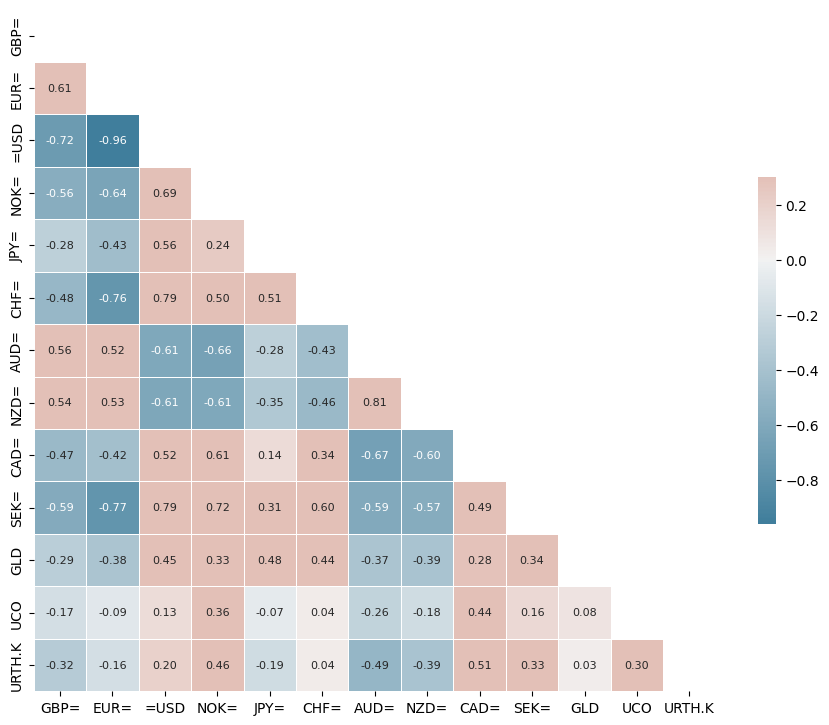

In [172]:
# Assuming 'data' is your DataFrame with each column being a time series of returns
correlation_matrix = arith_returns_scaled.corr()

# Using seaborn to create a heatmap of the correlation matrix
plt.figure(figsize=(16, 12))

# Generate a mask for the upper triangle.
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap.
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio.
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of the tick labels for clarity.
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [173]:
# Summary statistics
print(arith_returns_scaled.describe())
summary_stat_ret = arith_returns_scaled.describe()

""""
# Plotting all time series in the DataFrame
arith_returns.plot(figsize=(14, 7))
plt.title("Time series of asset returns")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()
"""

'''
# Box plot to visualize the distribution of returns
arith_returns_scaled.plot(kind='box', figsize=(10, 8))
plt.title("Box plot of asset returns")
plt.show()
'''

         GBP=    EUR=    =USD    NOK=    JPY=    CHF=    AUD=    NZD=    CAD=    SEK=     GLD  \
count 2508.00 2508.00 2508.00 2508.00 2508.00 2508.00 2508.00 2508.00 2508.00 2508.00 2508.00   
mean  0.00    0.00    -0.00   -0.00   -0.00   -0.00   0.00    0.00    -0.00   -0.00   0.00      
std   0.01    0.01    0.00    0.01    0.01    0.01    0.01    0.01    0.00    0.01    0.01      
min   -0.03   -0.03   -0.02   -0.05   -0.03   -0.03   -0.03   -0.03   -0.02   -0.04   -0.05     
25%   -0.00   -0.00   -0.00   -0.00   -0.00   -0.00   -0.00   -0.00   -0.00   -0.00   -0.00     
50%   0.00    0.00    -0.00   -0.00   -0.00   -0.00   -0.00   0.00    -0.00   -0.00   0.00      
75%   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00      
max   0.05    0.02    0.02    0.04    0.04    0.05    0.04    0.03    0.02    0.03    0.05      

          UCO  URTH.K  
count 2508.00 2508.00  
mean  0.00    0.00     
std   0.03    0.01     
min   -0.05   -0.05    
25%   

'\n# Box plot to visualize the distribution of returns\narith_returns_scaled.plot(kind=\'box\', figsize=(10, 8))\nplt.title("Box plot of asset returns")\nplt.show()\n'

In [174]:
'''
for column in arith_returns_scaled.columns:
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability
    arith_returns_scaled[column].hist(bins=50, alpha=0.7)
    plt.title(f"Histogram of {column} Returns")
    plt.xlabel("Returns")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
'''

'\nfor column in arith_returns_scaled.columns:\n    plt.figure(figsize=(10, 6))  # Set the figure size for better readability\n    arith_returns_scaled[column].hist(bins=50, alpha=0.7)\n    plt.title(f"Histogram of {column} Returns")\n    plt.xlabel("Returns")\n    plt.ylabel("Frequency")\n    plt.grid(True)\n    plt.show()\n'

<ipython-input-175-9e8107a07ab3>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



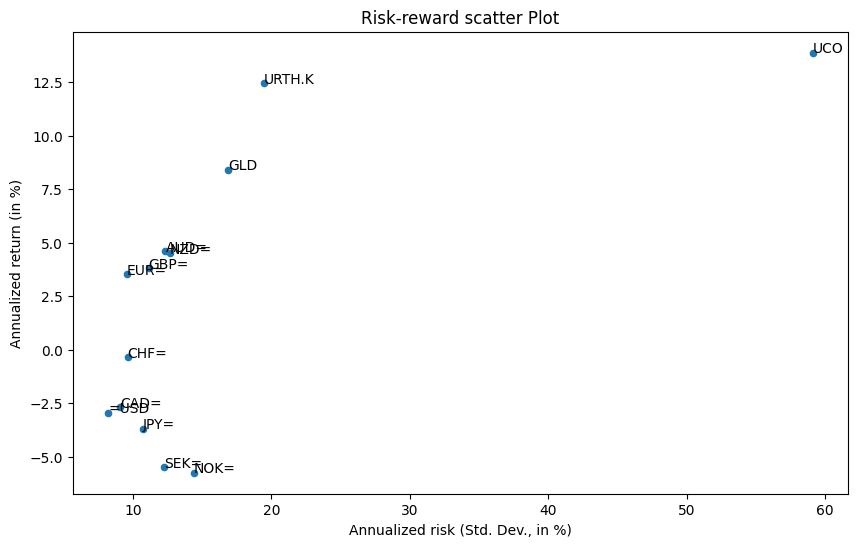

In [175]:
# Risk-Reward Scatter Plot
risk_reward = pd.DataFrame({
    'Return': arith_returns_scaled.mean() * 360 * 100,  # Annualize returns
    'Risk': arith_returns_scaled.std() * np.sqrt(360) * 100  # Annualize standard deviation
})
risk_reward.plot(kind='scatter', x='Risk', y='Return', figsize=(10, 6))
plt.title('Risk-reward scatter Plot')
plt.xlabel('Annualized risk (Std. Dev., in %)')
plt.ylabel('Annualized return (in %)')
for i, txt in enumerate(risk_reward.index):
    plt.annotate(txt, (risk_reward['Risk'][i], risk_reward['Return'][i]))

plt.show()

We aggregate our investment universe into different asset class groups to better capture the trends. We consolidated the 13 asset retained in the investment universe into six different groups. The way of grouping assets would helps us to think of the portfolio allocation process in a more macro-oriented approach.

In [176]:
# Define assets by category
assets = {
    'G10 Currencies': ["GBP=","EUR=","=USD","NOK=","JPY=","CHF=","AUD=","NZD=","CAD=","SEK="],
    'Oil': ["UCO"],
    'Gold': ["GLD"],
    'Global Equities' : ["URTH.K"]
}

In [177]:
# Create a reverse mapping from asset to class
asset_to_class = {asset: cls for cls, asset_list in assets.items() for asset in asset_list}

# Initialize an empty DataFrame to store class returns
class_returns = pd.DataFrame(index=arith_returns_scaled.index)

# Calculate returns for each class
for cls in assets.keys():
    # Filter assets belonging to the current class
    class_assets = [asset for asset in assets[cls] if asset in arith_returns_scaled.columns]

    # Calculate the mean return for the class
    class_returns[cls] = arith_returns_scaled[class_assets].mean(axis=1)

# Now 'class_returns' contains the average returns for each asset class


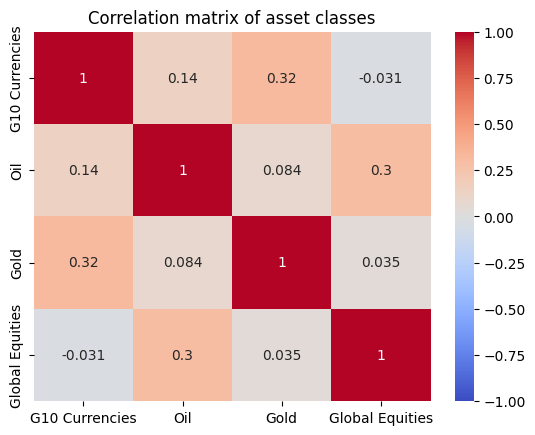

In [178]:
# Plot correlation matrix if more than one ticker in the category
asset_class_returns_corr = class_returns.dropna()
if len(asset_class_returns_corr) > 1:
    corr_matrix = asset_class_returns_corr.corr().round(3)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation matrix of asset classes")
    plt.show()

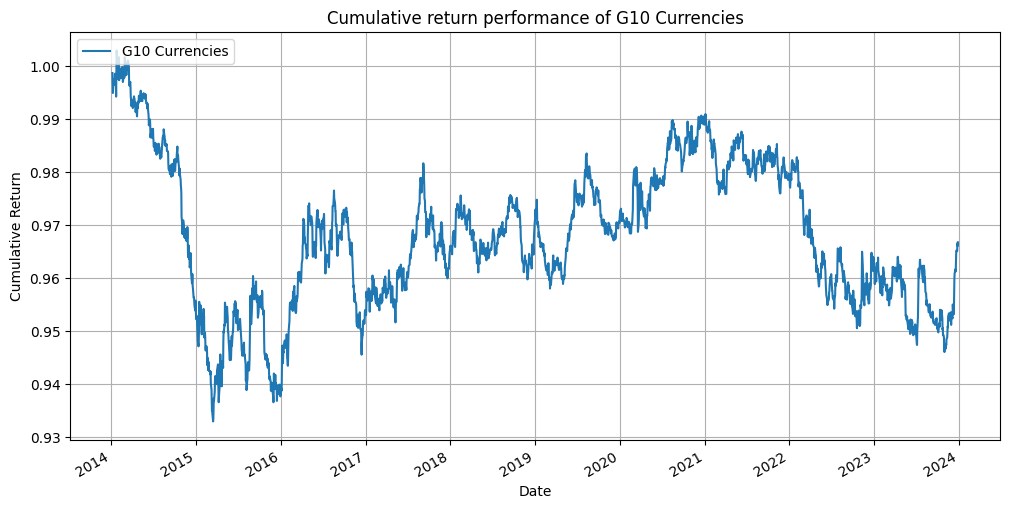

Statistical Data for G10 Currencies:

                Mean (in %)  Standard Deviation (in %)  Skewness  Kurtosis
G10 Currencies -0.45        2.59                       0.27      1.91     

--------------------------------------------------


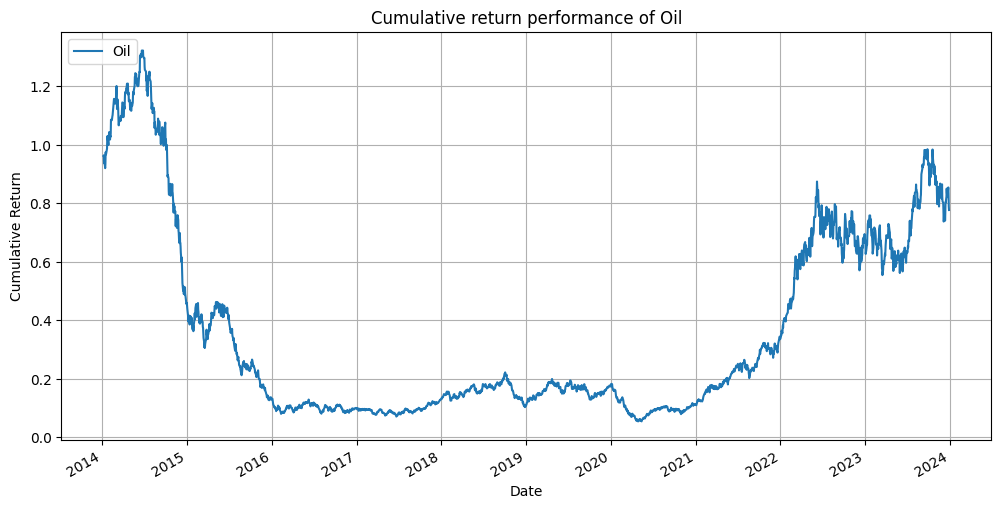

Statistical Data for Oil:

     Mean (in %)  Standard Deviation (in %)  Skewness  Kurtosis
Oil 13.88        59.10                      -0.09     -1.02    

--------------------------------------------------


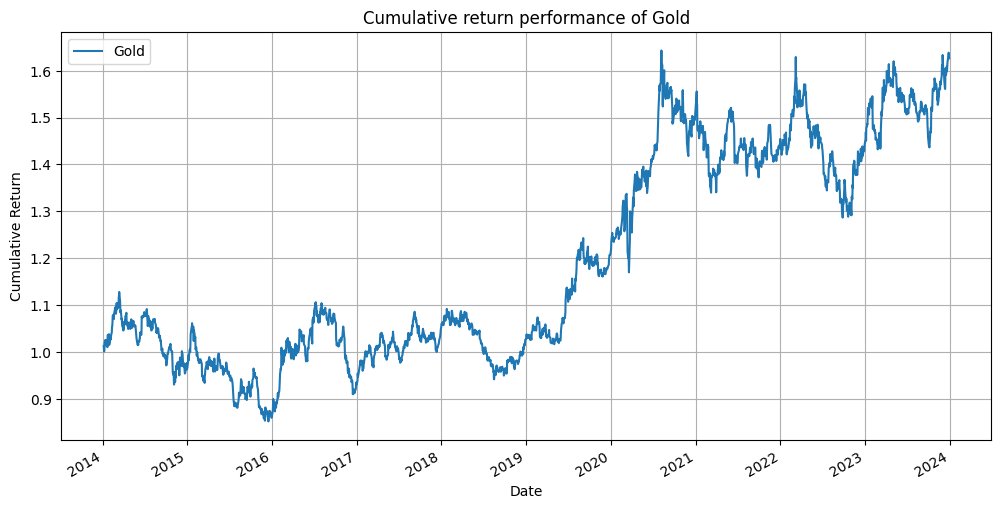

Statistical Data for Gold:

      Mean (in %)  Standard Deviation (in %)  Skewness  Kurtosis
Gold 8.40         16.87                      0.01      2.78     

--------------------------------------------------


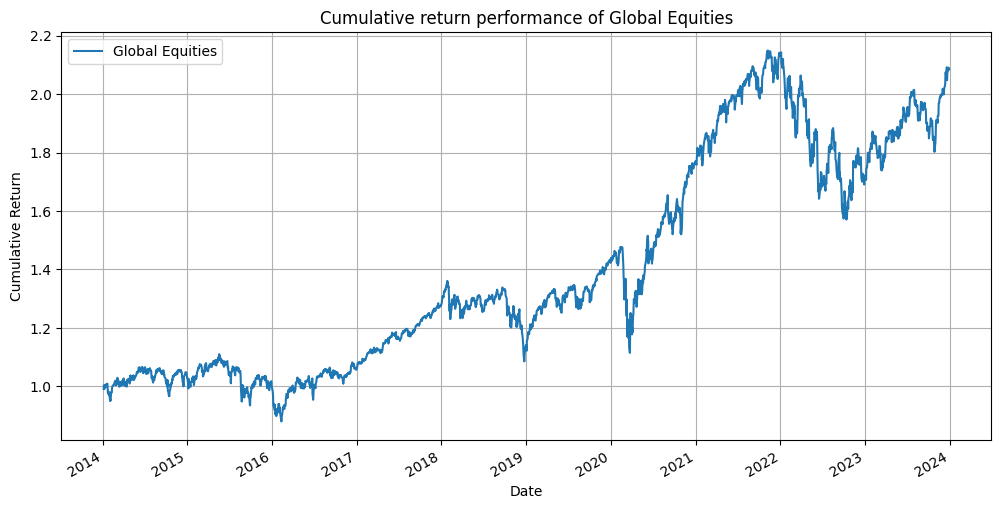

Statistical Data for Global Equities:

                 Mean (in %)  Standard Deviation (in %)  Skewness  Kurtosis
Global Equities 12.44        19.46                      -0.31     3.88     

--------------------------------------------------


In [179]:
from scipy.stats import skew, kurtosis

for category in class_returns.columns:
    asset_class_returns = class_returns[[category]].dropna()
    cumulative_returns = (1 + asset_class_returns).cumprod()

    # Plot cumulative return performance

    cumulative_returns.plot(figsize=(12, 6), title=f"Cumulative return performance of {category}")
    plt.ylabel("Cumulative Return")
    plt.xlabel("Date")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

    # Calculate statistical metrics

    stats = pd.DataFrame({
        "Mean (in %)": asset_class_returns.mean()*360 * 100,
        "Standard Deviation (in %)": asset_class_returns.std()*np.sqrt(360) * 100,
        "Skewness": skew(asset_class_returns),
        "Kurtosis": kurtosis(asset_class_returns)
    })

    print(f"Statistical Data for {category}:\n")
    print(stats)
    print("\n" + "-" * 50 + "\n")


In [180]:
# Initialize a list to store stats for each asset class
all_stats = []

# Loop through each asset class and calculate stats
for category in class_returns.columns:
    asset_class_returns = class_returns[[category]].dropna()
    # Calculate statistical metrics
    category_stats = {
        "Category": category,
        "Mean (in %)": asset_class_returns.mean()[0] * 360 * 100,
        "Standard Deviation (in %)": asset_class_returns.std()[0] * np.sqrt(360) * 100,
        "Sharpe Ratio" : asset_class_returns.mean()[0] * 360 * 100 / asset_class_returns.std()[0] * np.sqrt(360) * 100, #Risk-free rate is set at zero to as a simplification assumption
        "Skewness": skew(asset_class_returns)[0],
        "Kurtosis": kurtosis(asset_class_returns)[0]
    }
    # Append the dictionary to the list
    all_stats.append(category_stats)

# Create a DataFrame from the list of dictionaries
consolidated_stats_df = pd.DataFrame(all_stats)

# Set the index to the Category for readability
consolidated_stats_df.set_index('Category', inplace=True)

# Display the consolidated stats DataFrame
consolidated_stats_df

<ipython-input-180-2f08c639f9d4>:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-180-2f08c639f9d4>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-180-2f08c639f9d4>:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-180-2f08c639f9d4>:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consi

,Mean (in %),Standard Deviation (in %),Sharpe Ratio,Skewness,Kurtosis
Category,,,,,
G10 Currencies,-0.45,2.59,-628413.73,0.27,1.91
Oil,13.88,59.10,845377.28,-0.09,-1.02
Gold,8.40,16.87,1793396.08,0.01,2.78
Global Equities,12.44,19.46,2302284.49,-0.31,3.88


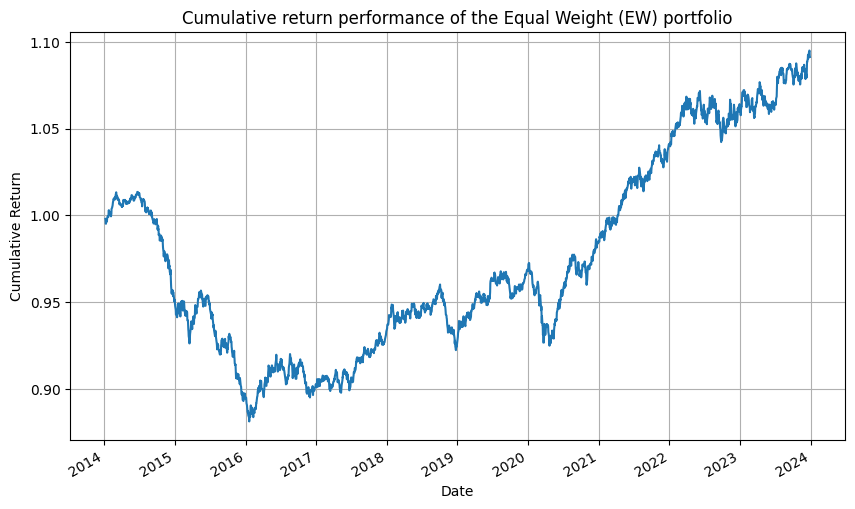

In [181]:
##Data and initial backtest

#Implementation of an equally weighted portfolio
# Calculate equal weights for each asset
num_assets = len(numeric_cols)
equal_weight = 1.0 / num_assets

# Calculate weighted returns for each asset
weighted_returns = arith_returns_scaled * equal_weight

# Calculate the daily return of the equal weight portfolio
portfolio_daily_return = weighted_returns.sum(axis=1)

# Calculate cumulative Returns for the portfolio
portfolio_cumulative_returns = (1 + portfolio_daily_return).cumprod()

# Plot cumulative return performance of the portfolio
plt.figure(figsize=(10, 6))
portfolio_cumulative_returns.plot(title="Cumulative return performance of the Equal Weight (EW) portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

We implemented a signal based strategy based on a simple moving average (200-day average) in order to capture the long term trends. After tilting the moving average window, we find out that the long term 200 offers the best results over the different rolling windows analysed.

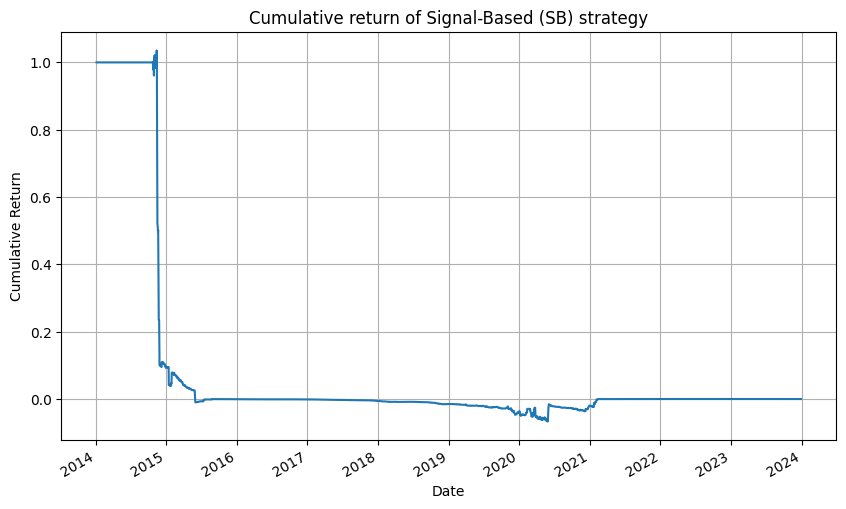

In [182]:
#Implementation of a simple signal strategy based on moving averages crossings.

# Calculate 200-day moving average for each asset
moving_average_200 = merged_df[numeric_cols].rolling(window=200).mean()

# Generate signal: 1 if current price is above 200-day MA, else 0
signal = (merged_df[numeric_cols] > moving_average_200).astype(int)

# Normalizing the signal to sum to 1 to get weights
weights = signal.div(signal.sum(axis=1), axis=0).dropna()

# Compute portfolio returns based on these weights
# Element-wise multiplication of returns by weights and sum across assets
SB_portfolio_returns = (arith_returns * weights.shift(1)).sum(axis=1).dropna()

# Calculate cumulative returns for the portfolio
SB_portfolio_cumulative_returns = (1 + SB_portfolio_returns).cumprod()

# Plot cumulative return performance of the strategy
plt.figure(figsize=(10, 6))
SB_portfolio_cumulative_returns.plot(title="Cumulative return of Signal-Based (SB) strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

## **2. Implementation of Portfolio Strategies (Portfolio Strategies Signal)**

In this part of the project, we elaborate on the portfolio management techniques that were implemented.

In [183]:
import pandas as pd

# Adjust display options
pd.set_option('display.max_rows', None)  # No limit on the number of rows displayed
pd.set_option('display.max_columns', None)  # No limit on the number of columns displayed
pd.set_option('display.width', None)  # Auto-detect the display width
pd.set_option('display.max_colwidth', 0)  # No limit on the column width

# Define the portfolio approaches and their utilities
data = {
    "Portfolio Approach": ["Mean-Variance (MV)", "Inverse Volatility", "Equal Risk Contribution (ERC)",
                           "Hierarchical Risk Parity (HRP)", "Maximum Sharpe Ratio (Maximum SR)", "Equal Weight", "Wall-Street Portfolio (WS)"],
    "Utility": [
        "Optimizes portfolio for the highest return per unit of risk, based on historical returns and volatilities.",
        "Allocates investment based on the inverse of the assets' volatilities, giving more weight to less volatile assets.",
        "Seeks to distribute risk equally among portfolio assets, aiming for each asset to contribute the same level of risk.",
        "Uses a hierarchical clustering algorithm to structure the portfolio into a hierarchy, optimizing for diversification and risk parity.",
        "Focuses on maximizing the Sharpe Ratio, selecting portfolio weights that offer the best expected return per unit of risk.",
        "Distributes capital evenly across all assets, ignoring market expectations, historical returns, or volatilities.",
        "Consensus of Wall-Street expectations on macroeconomic fundamentals for the different asset classes that covers our investment universe, based purely on a discretionary basis."
    ]
}

# Create the DataFrame
df_portfolio_approaches = pd.DataFrame(data).set_index('Portfolio Approach')

# Display the DataFrame
df_portfolio_approaches


,Utility
Portfolio Approach,
Mean-Variance (MV),"Optimizes portfolio for the highest return per unit of risk, based on historical returns and volatilities."
Inverse Volatility,"Allocates investment based on the inverse of the assets' volatilities, giving more weight to less volatile assets."
Equal Risk Contribution (ERC),"Seeks to distribute risk equally among portfolio assets, aiming for each asset to contribute the same level of risk."
Hierarchical Risk Parity (HRP),"Uses a hierarchical clustering algorithm to structure the portfolio into a hierarchy, optimizing for diversification and risk parity."
Maximum Sharpe Ratio (Maximum SR),"Focuses on maximizing the Sharpe Ratio, selecting portfolio weights that offer the best expected return per unit of risk."
Equal Weight,"Distributes capital evenly across all assets, ignoring market expectations, historical returns, or volatilities."
Wall-Street Portfolio (WS),"Consensus of Wall-Street expectations on macroeconomic fundamentals for the different asset classes that covers our investment universe, based purely on a discretionary basis."


### **Construction of portfolio strategies based on Riskfolio-lib package in Python**

We use the Riskfolio-lib package as an additional tool to check on the implemented strategies and compare overall results. We make an important use of it for the implementation of the Hierarchical Risk Parity (HRP) since its a technical procedure to implement and this package handles this type of portfolio allocation pretty easily and intuitively. Therefore, we will use the output given for the optimal portfolio computed on the full sample as the weights that will be used to compute the HRP returns.

In [184]:
#Using Riskfolio package

'''
https://github.com/dcajasn/Riskfolio-Lib/tree/master/examples
'''

import riskfolio as rp

#Fist strategy: Mean Variance portfolio construction

# Select method and estimate input parameters:
method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

# Building the portfolio object
port = rp.Portfolio(returns=arith_returns_scaled)

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk-free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_MV = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

w_MV_df = pd.DataFrame(w_MV)

display(w_MV.T)

,GBP=,EUR=,=USD,NOK=,JPY=,CHF=,AUD=,NZD=,CAD=,SEK=,GLD,UCO,URTH.K
weights,0.07,0.16,0.00,0.00,0.00,0.17,0.21,0.06,0.00,0.00,0.15,0.01,0.18


In [185]:
# Plotting the composition of the mean-variance portfolio

'''
ax_sharpeMV = rp.plot_pie(w=w_MV, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "viridis",
                 height=5, width=8, ax=None)
'''

'\nax_sharpeMV = rp.plot_pie(w=w_MV, title=\'Sharpe Mean Variance\', others=0.05, nrow=25, cmap = "viridis",\n                 height=5, width=8, ax=None)\n'

In [186]:
#Second strategy: Estimation of the Risk Parity Portfolios (ERP)

b = None # Risk contribution constraints vector
w_ERC = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)
display(w_ERC.T)

w_ERC_df = pd.DataFrame(w_ERC)

'''
#Plotting the RP portfolio
ax_RiskParity_Variance = rp.plot_pie(w=w_ERC, title='Risk Parity Variance', others=0.05, nrow=25, cmap = "viridis",
                 height=5, width=8, ax=None)
'''

,GBP=,EUR=,=USD,NOK=,JPY=,CHF=,AUD=,NZD=,CAD=,SEK=,GLD,UCO,URTH.K
weights,0.07,0.25,0.23,0.03,0.04,0.06,0.08,0.06,0.05,0.05,0.02,0.01,0.03


'\n#Plotting the RP portfolio\nax_RiskParity_Variance = rp.plot_pie(w=w_ERC, title=\'Risk Parity Variance\', others=0.05, nrow=25, cmap = "viridis",\n                 height=5, width=8, ax=None)\n'

**Theoretical foundations of Hierarchical Risk Parity (HRP) portfolio construction**

HRP is a quantitative management technique that is based on the construction of an allocation by focusing on the risk group of assets to form clusters and thus understand the behaviour of each asset by combining the investment universe. According to De Prado (2016), he elaborated extensively on the topic of HRP and highlighted that Mean-Variance (MV) portfolios are optimal in-sample, but perform poorly out-of-sample (even worse than the equally weighted portfolio). Studies, such as Michaud's (1998), indicate that quadratic optimizers typically give inaccurate results. One explanation for this is the difficulty in accurately forecasting returns. Small forecasting errors can cause significant differences that can be captured in the efficient frontier plot. We delve into the underlying technicalities for the HRP portfolio. To bridge that gap, De Prado (2016) formulated the following approach to construct HRP portfolios:

1. Tree Clustering: Organise comparable investments into clusters using an appropriate distance metric.
2. Quasi-diagonalization: Reorganise the rows and columns of the covariance matrix so that the biggest values are on the diagonal.
3. Split allocations using recursive bisection of the reordered covariance matrix.

**Tree clustering**

For the tree clustering and data quasi-diagonalisation, De Prado (2016) makes the following point.The only input needed is the correlation matrix, of size $N x N$.

1. Define the distance measure $d:\left(X_i, X_j\right) \subset B \rightarrow \mathbb{R} \in[0,1]$, $d_{i, j}=d\left[X_i, X_j\right]=\sqrt{\frac{1}{2}\left(1-\rho_{i, j}\right)}$, where $B$ is the Cartesian product of items in $\{1, \ldots, i, \ldots, N\}$. This forms a proper metric space $D$

2. Compute the Euclidean distance on $D, \tilde{d}:\left(D_i, D_j\right) \subset B \rightarrow \mathbb{R} \in$ $[0, \sqrt{N}]=\sqrt{\sum_{n=1}^N\left(d_{n, i}-d_{n, j}\right)^2}$

- Note the difference between distance metrics $d_{i, j}$ and $\tilde{d}_{i, j}$. Whereas $d_{i, j}$ is defined on column-vectors of $X, \tilde{d}_{i, j}$ is defined on column-vectors of $D$ (a distance of distances).

3. Cluster together the pair of columns $\left(i^*, j^*\right)$ such that
$$
\left(i^*, j^*\right)=\underset{\substack{i, j) \\ i \neq j}}{\operatorname{argmin}}\left\{\tilde{d}_{i, j}\right\}
$$
4. Update $\left\{\tilde{d}_{i, j}\right\}$ with the new cluster

5. Apply steps $3-4$ recursively until all $N-1$ clusters are formed

  - Similar items are clustered together, in a tree structure where two leaves are bundled together at each iteration

  - The dendogram's y-axis reports the distance between the two joining leaves

**Quasi-diagonalisation**

  - This stage places correlated items together, and uncorrelated items far apart. This is accomplished by replacing clusters with their components recursively, until no clusters remain.

  - Replacements preserve the order of the clustering.

1. Because the resulting covariance is quasi-diagonal, we define the variance of a continuous subset $L_i \in L$ as the quadratic form $\tilde{V}_i \equiv \widetilde{w}_i{ }^{\prime} V_i \widetilde{w}_i$, where $L$ is the sorted list of all items and $\quad V_i$ is the covariance matrix between the constituents of subset $L_i$ $\widetilde{w}_i=\operatorname{diag}\left[V_i\right]^{-1} \frac{1}{\operatorname{tr}\left[\operatorname{diag}\left[V_i\right]^{-1}\right]^{\prime}}$, where $\operatorname{diag}[$.$] and$ $\operatorname{tr}[$. $]$ are the diagonal and trace operators $\quad$

2. This definition of $\tilde{V}_i$ is motivated by the fact that the inverse-variance allocation is optimal for a diagonal covariance matrix

**Bi-section approach**

The HRP approach aims to create a portfolio that diversifies risk more effectively compared to traditional portfolio construction methods.

1. Assigning Weights:

- Initially, assign a unit weight to all items in the portfolio. If there are $N$ assets, each asset $n$ gets a weight $w_n=1$.

2. Recursive Bisection:
- The list $L_i$ of all items (assets) is divided into two sub-lists $L_i^{(1)}$ and $L_i^{(2)}$. This is done recursively, meaning that each sub-list is further divided until there are lists that cannot be split anymore (i.e., they contain only one item).

3. Computing Variances:
- Calculate the variance $\tilde{V}_i^{(j)}$ for each of the two sub-lists obtained after the bisection. The variance measures the dispersion of asset returns and is used to assess risk.

4. Split Factor:
- Determine a split factor $\alpha_i$ using the variances of the two sub-lists. This factor is used to allocate weights between the two sub-lists in a way that reflects their relative risk. It's calculated such that it lies between 0 and 1. The formula given is a method to ensure that risk is split inversely to the variances; the list with the lower variance gets a higher weight.

5. Re-scaling Allocations for $L_i^{(1)}$ :
- Adjust the weights $w_n$ for all $n$ in sub-list $L_i^{(1)}$ by multiplying them by $\alpha_i$. This increases the weights of assets in the lower-risk sub-list.

6. Re-scaling Allocations for $L_i^{(2)}$ :
- Similarly, adjust the weights $w_n$ for all $n$ in sub-list $L_i^{(2)}$ by multiplying them by $\left(1-\alpha_i\right)$. This decreases the weights of assets in the higher-risk sub-list.

7. Stopping condition:
- The process ends when each sub-list $L_i$ contains only one item. At this point, each asset has been assigned a weight that reflects its $\downarrow$ tribution to the overall risk of the portfolio.

The recursive bisection process takes advantage of the "quasi-diagonalization" of the covariance matrix. Quasi-diagonalization is a process that reorders the covariance matrix to place the most correlated assets closer together, simplifying the process of dividing them into clusters.

This HRP method is designed to construct a portfolio that not only considers the individual risk of assets but also their correlations, leading to a more balanced distribution of risk across the portfolio.

In [187]:
#Third strategy: Implementing Hierarchical Risk Parity (HRP) portfolio

# Building the portfolio object
port = rp.HCPortfolio(returns=arith_returns_scaled)

# Estimate optimal portfolio:

model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'ward' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic
leaf_order = True # Consider optimal order of leafs in dendrogram

w_HRP = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

w_HRP_df = pd.DataFrame(w_HRP)
display(w_HRP.T)

,GBP=,EUR=,=USD,NOK=,JPY=,CHF=,AUD=,NZD=,CAD=,SEK=,GLD,UCO,URTH.K
weights,0.05,0.28,0.07,0.03,0.05,0.05,0.04,0.06,0.27,0.04,0.02,0.01,0.03


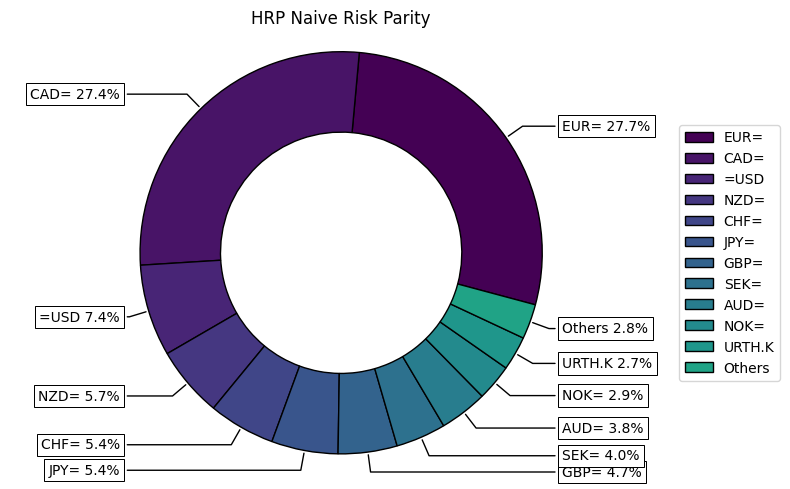

In [188]:
# Plotting the composition of the portfolio

ax_HRP_clustering_weights = rp.plot_pie(w=w_HRP,
                 title='HRP Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="viridis",
                 height=5,
                 width=8,
                 ax=None)

### **Portfolio Strategies**

In [189]:
# For Equally Weighted (EW) portfolio
num_assets = len(arith_returns_scaled.columns)
equal_weights = 1 / num_assets
eq_weighted_returns = arith_returns_scaled * equal_weights
eq_portfolio_returns = eq_weighted_returns.sum(axis=1)

The Wall-Street portfolio is a benchmark portfolio strategy that we want to test and add in our overall analysis. It is based on the market outlook and recommendation from three main Wall-Street actors (JP Morgan AM, Goldman Sachs AM and BlackRock). This portfolio is based on Wall-Street outlook on the economy and the overall macro environment. We use the 2024 market outlook from Goldman Sachs Asset Management (GS AM), JPMorgan Asset Management (JPM AM), and BlackRock as the Wall Street consensus to construct the benchmark with their proposed asset allocation strategies.

- For G10 FX currencies and short-rerm rates, Wall Street expects gradual monetary policy normalisation and the possibility of an economic slowdown to result in a neutral to slightly underweight stance. The emphasis would be on currencies with solid fundamentals and growth potential.

- For US long-term bonds, Wall Street expects elevated yields and the possibility of interest rate hikes, justifying a slightly overweight allocation. Consider higher-quality bonds with shorter durations.

- In terms of oil, there are a variety of factors that can influence oil prices, including price expectations, geopolitical risks, and economic conditions, indicating a neutral to slightly underweight position. Strategies centred on oil-producing regions or specific companies with strong fundamentals may be considered.

- Wall Street expects gold's relative stability, diversification benefits, and inflation hedge potential to support a neutral to slightly overweight stance. A strategic allocation to gold in portfolios is recommended.

- An overweight allocation to global equities is warranted given the expectation of moderate growth and the potential for volatility. It is critical to select sectors, diversify across regions, and implement risk management strategies.

Based on the above outlooks, a potential Wall Street benchmark portfolio for 2024 could include the following asset class weights:

| Asset Class | GS AM | JPM AM | BlackRock | WS Benchmark |
|---|---|---|---|-----------------------|
| G10 Currencies | Neutral | Neutral | Neutral | 5%                    |
| G10 Short-Term Rates | Neutral | Neutral | Neutral | 0%                   |             |
| Oil | Range-bound | Neutral | Neutral| 2.5%                    |
| Gold | Overweight | Neutral | Neutral | 52.5%                   |
| Global Equities | Overweight | Overweight | Overweight | 40%                   |

In [190]:
# Wall Street (WS) portfolio
class_weights = {"G10 Currencies": 0.05,"Oil": 0.025, "Gold": 0.525, "Global Equities": 0.4}
asset_classification = {asset: asset_class for asset_class, asset_list in assets.items() for asset in asset_list}

# Allocate these weights to individual assets
ws_weights = {}
for asset in arith_returns_scaled.columns:
    asset_class = asset_classification[asset]
    class_asset_count = sum(1 for a in arith_returns_scaled.columns if asset_classification[a] == asset_class)
    ws_weights[asset] = class_weights[asset_class] / class_asset_count

#For the Wall Street portfolio
ws_weighted_returns = arith_returns_scaled.mul(pd.Series(ws_weights), axis=1)
ws_portfolio_returns = ws_weighted_returns.sum(axis=1)

We implement the classical Mean Variance (MV) portfolio in a Markowitz framework, and seek to compute the minimum variance portfolio which captures the portfolio with the lowest level of risk and is located in the lower tier of the efficient frontier.

In [191]:
from scipy.optimize import minimize

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_vol = portfolio_volatility(weights, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_vol

def optimize_portfolio(returns, method, risk_free_rate=0.0):
    # Ensure there are no negative or zero values in the returns to avoid unrealistic optimization results
    returns = returns.clip(lower=1e-4)

    # Calculate the covariance matrix
    cov_matrix = returns.cov()

    # Initial guess for the weights
    initial_guess = np.full(returns.shape[1], 1 / returns.shape[1])

    # Bounds for the weights
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    # Constraint: weights sum to 1
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    # Optimization
    if method == 'MV':
        # Minimize volatility
        result = minimize(portfolio_volatility, initial_guess, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints)
    elif method == 'IVol':
        # Maximize inverse volatility
        result = minimize(lambda w: -1 / portfolio_volatility(w, cov_matrix), initial_guess,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    elif method == 'ERC':
        # Equal risk contribution - minimize the difference in contribution to risk
        def risk_parity_objective(w, cov_matrix):
            marginal_risk = cov_matrix @ w
            total_risk = w @ marginal_risk
            risk_contributions = w * marginal_risk / total_risk
            return np.sum((risk_contributions - 1 / len(w)) ** 2)

        result = minimize(risk_parity_objective, initial_guess, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints)
    elif method == 'Sharpe':
        # Maximize Sharpe ratio
        expected_returns = returns.mean() * 252
        result = minimize(negative_sharpe_ratio, initial_guess,
                          args=(expected_returns, cov_matrix, risk_free_rate),
                          method='SLSQP', bounds=bounds, constraints=constraints)

    # Check if the optimization was successful
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)

    # Return the optimized weights
    return result.x

optimized_weights_mv = optimize_portfolio(arith_returns_scaled, 'MV')
optimized_weights_ivol = optimize_portfolio(arith_returns_scaled, 'IVol')
optimized_weights_erc = optimize_portfolio(arith_returns_scaled, 'ERC')
optimized_weights_sharpe = optimize_portfolio(arith_returns_scaled, 'Sharpe', risk_free_rate=0.00)

print(optimized_weights_mv)
print(optimized_weights_ivol)
print(optimized_weights_erc)
print(optimized_weights_sharpe)

[0.10126684 0.21690487 0.13524038 0.00221889 0.07178347 0.09895145
 0.05244686 0.05573688 0.2057347  0.05942429 0.         0.
 0.00029139]
[7.73975811e-02 2.33682832e-01 2.53151151e-01 0.00000000e+00
 4.00100146e-02 4.68918585e-02 5.85555965e-02 5.62367291e-02
 2.13493134e-01 1.74047049e-02 1.47725756e-03 8.77886250e-10
 1.69914052e-03]
[0.00000000e+00 0.00000000e+00 1.40167022e-01 8.78356087e-02
 1.51354154e-01 1.35270378e-01 0.00000000e+00 1.17265254e-17
 1.53415569e-01 1.07573976e-01 9.44068242e-02 3.69419274e-02
 9.30345402e-02]
[0.07680414 0.18012028 0.         0.00570655 0.07181689 0.08804419
 0.10973379 0.09814227 0.09450225 0.11550026 0.06567202 0.03484419
 0.05911319]


In [192]:
assets = [
    "GBP", "EUR", "USD", "NOK",
    "JPY", "CHF", "AUD", "NZD",
    "CAD", "SEK", "GLD", "UCO",
    "URTH.K"
]

# Optimized weights for each strategy, replace the ellipses with actual numbers
optimized_weights_mv = [
    1.01266837e-01, 2.16904883e-01, 1.35240385e-01, 2.21887325e-03,
    7.17834653e-02, 9.89514535e-02, 5.24468493e-02, 5.57368725e-02,
    2.05734715e-01, 5.94242870e-02, 2.73761049e-18, 8.06375366e-19,
    2.91379090e-04
]
optimized_weights_ivol = [
    7.73975806e-02, 2.33682831e-01, 2.53151129e-01, 0.00000000e+00,
    4.00100183e-02, 4.68918651e-02, 5.85555981e-02, 5.62367287e-02,
    2.13493145e-01, 1.74047062e-02, 1.47725730e-03, 7.85428663e-10,
    1.69914007e-03
]
optimized_weights_erc = [
    5.79418216e-17, 1.66642982e-16, 1.40167021e-01, 8.78356087e-02,
    1.51354155e-01, 1.35270379e-01, 6.26434622e-17, 8.50372823e-17,
    1.53415567e-01, 1.07573976e-01, 9.44068241e-02, 3.69419275e-02,
    9.30345407e-02
]
optimized_weights_sharpe = [
    7.68041371e-02, 1.80120283e-01, 1.25823887e-13, 5.70654692e-03,
    7.18168863e-02, 8.80441953e-02, 1.09733790e-01, 9.81422658e-02,
    9.45022438e-02, 1.15500254e-01, 6.56720205e-02, 3.48441878e-02,
    3.48441878e-02
]

# Now we consolidate the weights into dictionaries for each strategy
strategies = {
    'MV': dict(zip(assets, optimized_weights_mv)),
    'IVol': dict(zip(assets, optimized_weights_ivol)),
    'ERC': dict(zip(assets, optimized_weights_erc)),
    'Sharpe': dict(zip(assets, optimized_weights_sharpe))
}

# Create a DataFrame from the strategies_weights dictionary
strategies_df = pd.DataFrame(strategies)
print(strategies_df)

# Convert the strategies weights into individual dataframes for each strategy
mv_df = pd.DataFrame({'MV': optimized_weights_mv}, index=assets)
ivol_df = pd.DataFrame({'IVol': optimized_weights_ivol}, index=assets)
erc_df = pd.DataFrame({'ERC': optimized_weights_erc}, index=assets)
sharpe_df = pd.DataFrame({'Sharpe': optimized_weights_sharpe}, index=assets)

'''
mv_df, ivol_df, erc_df, sharpe_df
'''

         MV  IVol  ERC  Sharpe
GBP    0.10 0.08  0.00 0.08   
EUR    0.22 0.23  0.00 0.18   
USD    0.14 0.25  0.14 0.00   
NOK    0.00 0.00  0.09 0.01   
JPY    0.07 0.04  0.15 0.07   
CHF    0.10 0.05  0.14 0.09   
AUD    0.05 0.06  0.00 0.11   
NZD    0.06 0.06  0.00 0.10   
CAD    0.21 0.21  0.15 0.09   
SEK    0.06 0.02  0.11 0.12   
GLD    0.00 0.00  0.09 0.07   
UCO    0.00 0.00  0.04 0.03   
URTH.K 0.00 0.00  0.09 0.03   


'\nmv_df, ivol_df, erc_df, sharpe_df\n'

Since implementing this strategy is challenging and required an advanced comprehension of the underlying model technique, we use the results obtained from the previous HRP computations performed using the riskfolio-lib package.

In [193]:
#Appliying Hierarchical Risk Parity

# Manually input the weights into a DataFrame
HRP_weights_data = {
    'GBP=': 0.047379, 'EUR=': 0.277265, '=USD': 0.073784, 'NOK=': 0.029294,
    'JPY=': 0.053505, 'CHF=': 0.053554, 'AUD=': 0.038454, 'NZD=': 0.056849,
    'CAD=': 0.274255, 'SEK=': 0.040264, 'GLD': 0.021566, 'UCO': 0.006430,
    'URTH.K': 0.027400
}

# Creating a DataFrame from the HRP_weights_data dictionary
HRP_weights_df = pd.DataFrame([HRP_weights_data])

# Convert the weights dictionary into a DataFrame
HRP_weight_df = pd.DataFrame.from_dict(HRP_weights_data, orient='index', columns=['weights'])

# Transpose the weights dataframe to align with the returns dataframe
HRP_weights_df = HRP_weight_df.T

# Assuming 'arith_returns_scaled' is your DataFrame of asset returns
# Align the weights with the columns of the returns DataFrame

HRP_return_adapted = arith_returns_scaled
HRP_return_columns_adapted = arith_returns_scaled.columns
weights_aligned = HRP_weights_df.reindex(columns=HRP_return_adapted.columns).fillna(0)

# Compute the weighted returns
weighted_returns = arith_returns_scaled * weights_aligned.values

# Compute the daily HRP portfolio returns
HRP_returns = weighted_returns.sum(axis=1)


In [194]:
#Compute daily returns for each strategy

# Calculate daily portfolio returns
MV_returns = arith_returns_scaled.mul(mv_df.squeeze(), axis=1).sum(axis=1)
IVol_returns = arith_returns_scaled.mul(ivol_df.squeeze(), axis=1).sum(axis=1)
ERC_returns = arith_returns_scaled.mul(erc_df.squeeze(), axis=1).sum(axis=1)
Sharpe_returns = arith_returns_scaled.mul(sharpe_df.squeeze(), axis=1).sum(axis=1)

EW_returns = (arith_returns_scaled * equal_weights).sum(axis=1)
WS_returns = (arith_returns_scaled * ws_weights).sum(axis=1)

# Concatenate them into a single DataFrame like this:
consolidated_portfolio_returns = pd.concat([
    MV_returns, IVol_returns, ERC_returns, EW_returns, Sharpe_returns, WS_returns, HRP_returns
], axis=1)
# Give appropriate column names corresponding to each strategy:
consolidated_portfolio_returns.columns = ['MV', 'Inv_vol', 'ERC','EW', 'SR', 'WS', 'HRP']

In [195]:
# For MV portfolio
MV_portfolio_mean_return = MV_returns.mean()* 360 * 100
MV_portfolio_volatility = MV_returns.std()* np.sqrt(360) * 100

# For ERC portfolio
ERC_portfolio_mean_return = ERC_returns.mean()* 360 * 100
ERC_portfolio_volatility = ERC_returns.std()* np.sqrt(360) * 100

# For Inverse of Volatility (Ivol) Portfolio
IVol_portfolio_mean_return = IVol_returns.mean()* 360 * 100
IVol_portfolio_volatility = IVol_returns.std()* np.sqrt(360) * 100


# For Hierarchical Risk Parity (HRP) Portfolio
HRP_portfolio_mean_return = HRP_returns.mean()* 360 * 100
HRP_portfolio_volatility = HRP_returns.std()* np.sqrt(360) * 100


# For Equally Weighted Portfolio
EW_portfolio_mean_return = eq_portfolio_returns.mean()* 360 * 100
EW_portfolio_volatility = eq_portfolio_returns.std()* np.sqrt(360) * 100

# For Wall Street Portfolio
WS_portfolio_mean_return = ws_portfolio_returns.mean()* 360 * 100
WS_portfolio_volatility = ws_portfolio_returns.std()* np.sqrt(360) * 100

In [196]:
portfolios = {
    "MV": MV_returns,
    "ERC": ERC_returns,
    "IVol": IVol_returns,
    "HRP": HRP_returns,
    "EW": eq_portfolio_returns,
    "WS": ws_portfolio_returns
}

# Create an empty dictionary to store performance metrics
portfolio_performance_metrics = {
    "Strategy": [],
    "Annualized Return (%)": [],
    "Annualized Volatility (%)": []
}

# Calculate the annualized return and volatility for each portfolio
for portfolio_name, returns in portfolios.items():
    portfolio_performance_metrics["Strategy"].append(portfolio_name)
    portfolio_performance_metrics["Annualized Return (%)"].append(returns.mean() * 360 *100)
    portfolio_performance_metrics["Annualized Volatility (%)"].append(returns.std() * np.sqrt(360)* 100)

# Create a DataFrame from the performance metrics dictionary
portfolio_performance_df = pd.DataFrame(portfolio_performance_metrics)

# Now 'portfolio_performance_df' is a DataFrame with the performance metrics for each portfolio
portfolio_performance_df

,Strategy,Annualized Return (%),Annualized Volatility (%)
0,MV,0.00,0.01
1,ERC,2.46,3.71
2,IVol,0.03,0.04
3,HRP,0.64,2.70
4,EW,2.32,6.14
5,WS,9.71,12.48


<Axes: title={'center': 'Cumulative Return of strategies'}, xlabel='Date'>

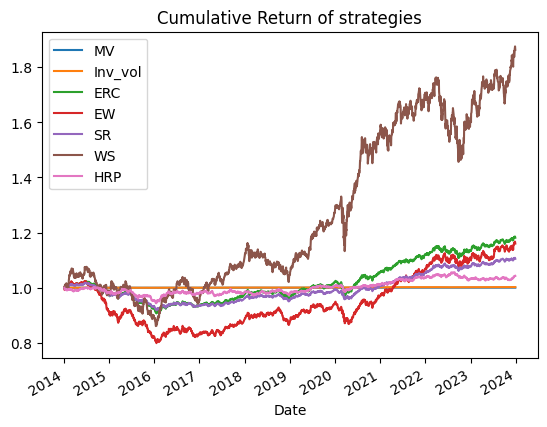

In [197]:
#Calculate cumulative returns

cumulative_returns = (1 + consolidated_portfolio_returns).cumprod()
cumulative_returns.plot(title="Cumulative Return of strategies")

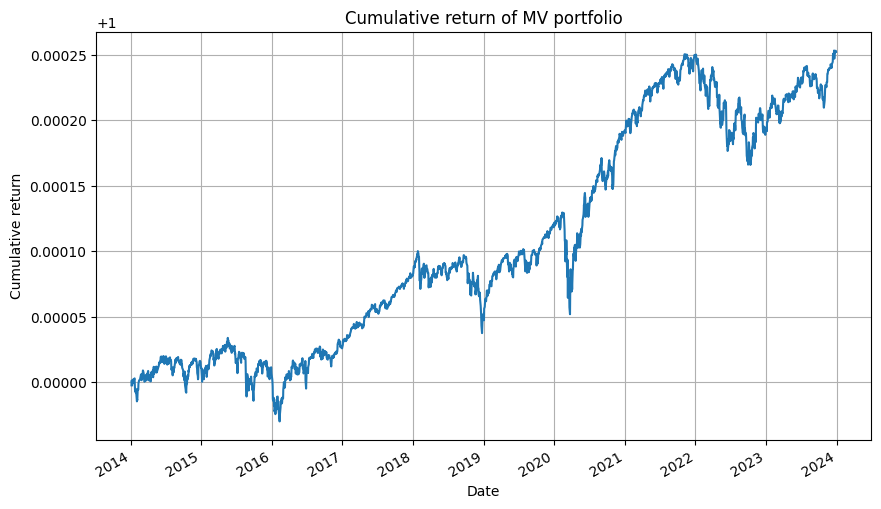

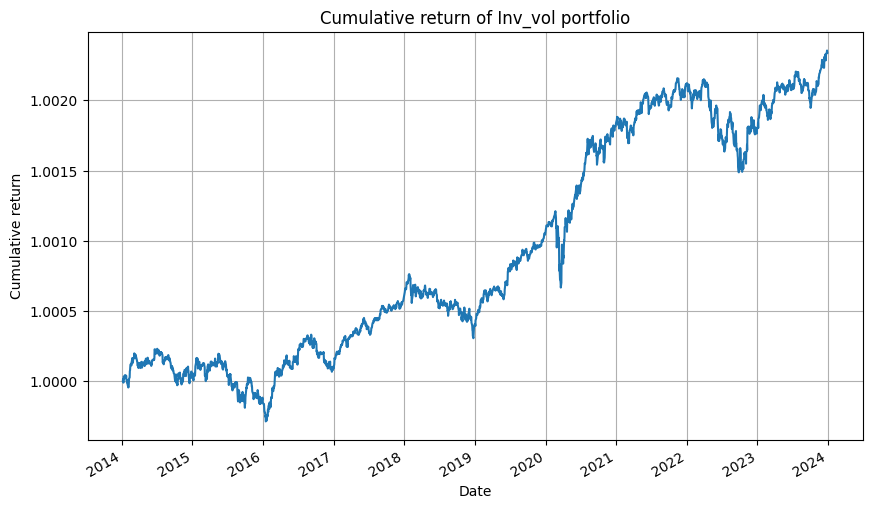

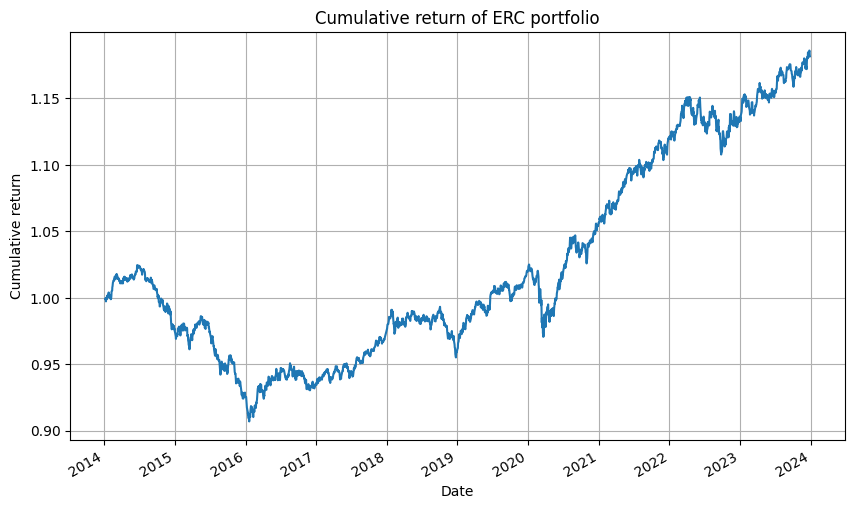

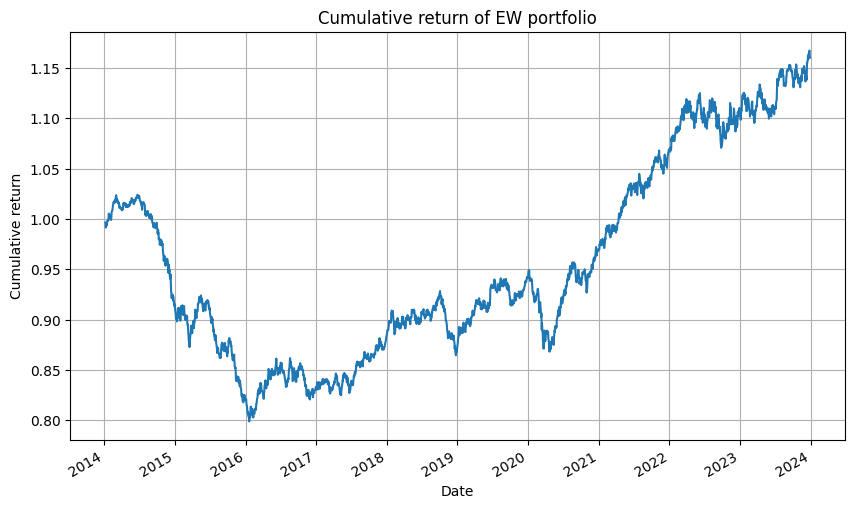

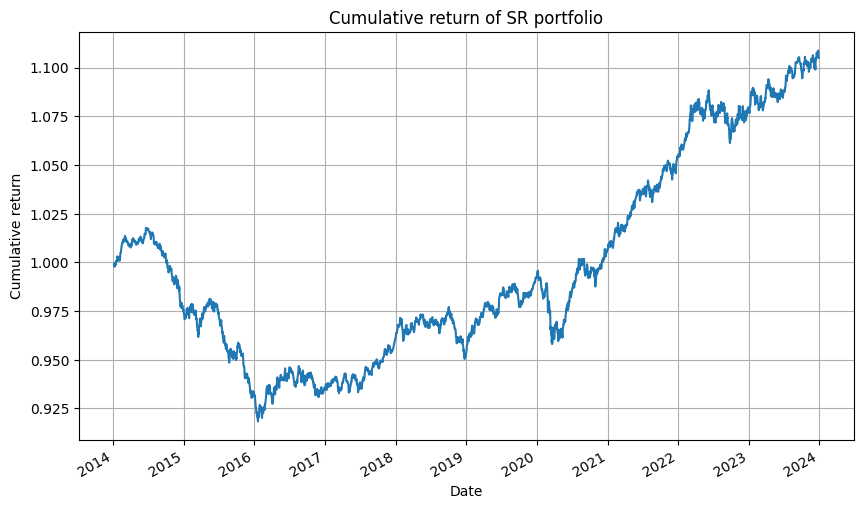

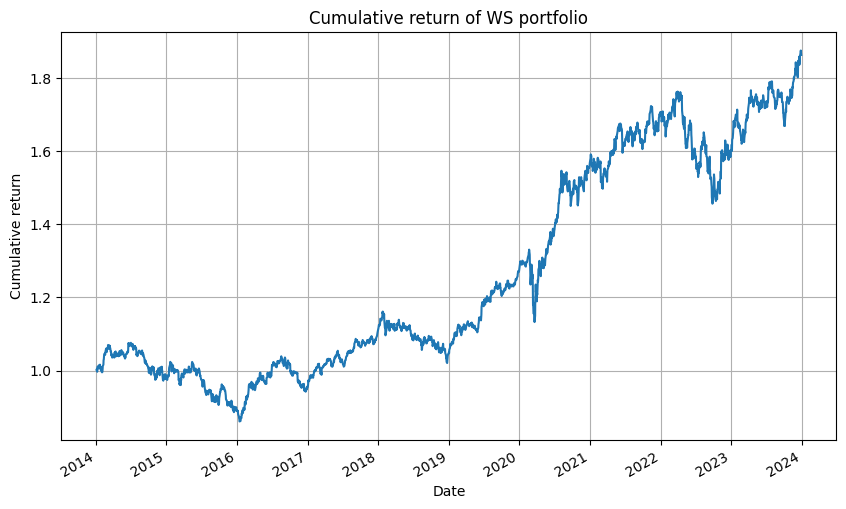

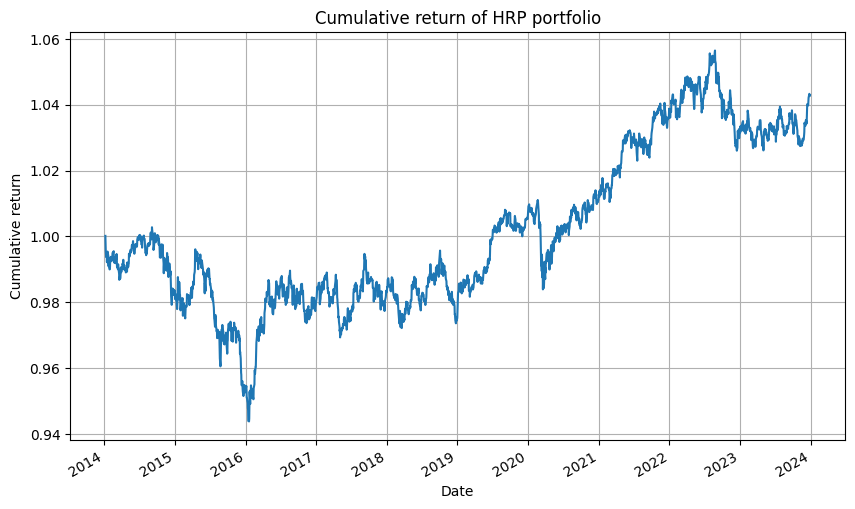

In [198]:
# Assuming 'consolidated_portfolio_returns' contains the daily returns of each strategy
strategies = ['MV','Inv_vol','ERC', 'EW', 'SR', 'WS', 'HRP']  # List of all strategies

# Loop through each strategy to calculate and plot cumulative returns
for strategy in strategies:
    # Calculate cumulative returns
    cumulative_returns = (1 + consolidated_portfolio_returns[strategy]).cumprod()

    # Plot cumulative returns
    plt.figure(figsize=(10, 6))
    cumulative_returns.plot(title=f"Cumulative return of {strategy} portfolio")
    plt.xlabel("Date")
    plt.ylabel("Cumulative return")
    plt.grid(True)
    plt.show()

## **3. Basic Portfolio Analysis**

In [199]:
# Define the function to calculate performance metrics
def calculate_performance_metrics(portfolio_returns, risk_free_rate=0):
    # Annualize the risk-free rate (assuming it's provided on an annual basis)
    risk_free_rate_daily = (1 + risk_free_rate) ** (1/360) - 1

    # Initialize a dictionary to store the results
    metrics = {
        "Total performance": [],
        "Annualized return": [],
        "Annualized volatility": [],
        "Annualized Sharpe Ratio": [],
    }

    # Loop over each strategy and calculate performance metrics
    for strategy in portfolio_returns.columns:
        # Total performance (cumulative return)
        cumulative_return = (1 + portfolio_returns[strategy]).cumprod()[-1]
        metrics["Total performance"].append(cumulative_return - 1)

        # Average daily return
        annualized_return = portfolio_returns[strategy].mean() * (360)
        metrics["Annualized return"].append(annualized_return)

        # Annualized volatility
        annualized_volatility = portfolio_returns[strategy].std() * (360 ** 0.5)
        metrics["Annualized volatility"].append(annualized_volatility)

        # Annualized Sharpe Ratio
        sharpe_ratio = (annualized_return - risk_free_rate_daily) / annualized_volatility
        metrics["Annualized Sharpe Ratio"].append(sharpe_ratio * (360 ** 0.5))


    # Convert metrics dictionary to DataFrame
    performance_metrics_df = pd.DataFrame(metrics, index=portfolio_returns.columns)

    # Format the DataFrame for better readability
    performance_metrics_df["Total performance"] = performance_metrics_df["Total performance"].map('{:.2%}'.format)
    performance_metrics_df["Annualized return"] = performance_metrics_df["Annualized return"].map('{:.4%}'.format)
    performance_metrics_df["Annualized volatility"] = performance_metrics_df["Annualized volatility"].map('{:.2%}'.format)
    performance_metrics_df["Annualized Sharpe Ratio"] = performance_metrics_df["Annualized Sharpe Ratio"].map('{:.2f}'.format)

    return performance_metrics_df

# Calculate the performance metrics
risk_free_rate_annual = 0.00
performance_metrics_df = calculate_performance_metrics(consolidated_portfolio_returns, risk_free_rate_annual)

# Display the performance metrics table
performance_metrics_df.reset_index().rename(columns={"index": "Strategy"})

<ipython-input-199-3ab8c1e31070>:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



,Strategy,Total performance,Annualized return,Annualized volatility,Annualized Sharpe Ratio
0,MV,0.03%,0.0036%,0.01%,12.13
1,Inv_vol,0.23%,0.0336%,0.04%,15.13
2,ERC,18.16%,2.4637%,3.71%,12.60
3,EW,16.04%,2.3239%,6.14%,7.18
4,SR,10.50%,1.4691%,2.68%,10.38
5,WS,86.33%,9.7138%,12.48%,14.76
6,HRP,4.29%,0.6392%,2.70%,4.49


## **4. Portfolio Strategies Risk Management**

For the portfolio risk management, we implemented a simple drawdown framework where we assess the assets selected in terms of their maximum loss, and seek for patterns related to their market behavior. We consolidate our risk framework in the part five of the project where we introduce VaR computation as a supplementary tool to make informed decision and compare strategies based on their risk.

The following drawdown plot compares the performance of various portfolio optimisation techniques over time, specifically how each strategy's value has decreased from a previous peak over a certain period. Drawdown is a measure of downside risk that represents an asset's peak-to-trough fall over a certain time period. It is typically expressed as a percentage between the peak and the subsequent trough.

Below is a breakdown of what the plot reveals for each portfolio strategy:

* MV (Mean-Variance): This method appears to have had mild drawdowns over time, with some notable falls indicating periods of increased risk or market downturns.

* Inv_vol (Inverse Volatility): This approach shows a drawdown pattern similar to the MV, but with some periods of lesser drawdowns, implying that it may be less risky than the MV, potentially due to its focus on lower volatility assets.

* ERC (Equal Risk Contribution): The ERC strategy's drawdowns are fewer than those of the MV strategy, indicating that risk is possibly distributed more evenly across portfolio assets.

* EW (Equal Weight): This strategy has seen several periods of substantial drawdowns, demonstrating that equal weighting across assets may not always protect against large market moves. It may perform similarly to a market index because all assets are handled identically, regardless of risk.

* SR (Sharpe Ratio): The strategy aimed at maximising the Sharpe Ratio, which measures risk-adjusted return, features periods of both large and low drawdowns, reflecting fluctuations in either the projected return or portfolio volatility.

* WS (Wall Street portfolio): This approach, which may be based on Wall Street consensus and discretionary selection, has shown mixed results, with some of the biggest drawdowns, implying that it is more aggressive or speculative.

* HRP (Hierarchical Risk Parity): The HRP approach often exhibits more limited drawdowns over time, which may indicate more consistent risk management that considers asset correlations.

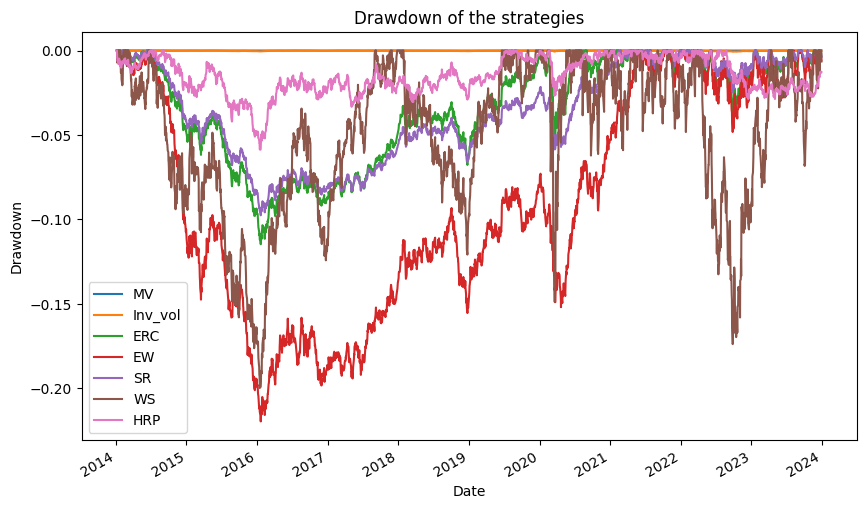

In [200]:
# Calculate the cumulative returns
cumulative_returns = (1 + consolidated_portfolio_returns).cumprod()

# Calculate the drawdown
drawdown = cumulative_returns.div(cumulative_returns.cummax()).subtract(1)

# Plot the drawdown
drawdown.plot(figsize=(10, 6))
plt.title('Drawdown of the strategies')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.show()

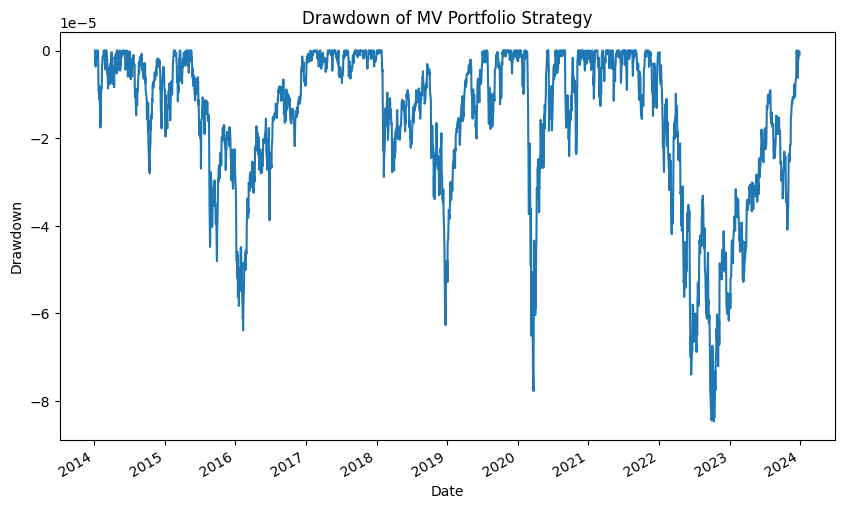

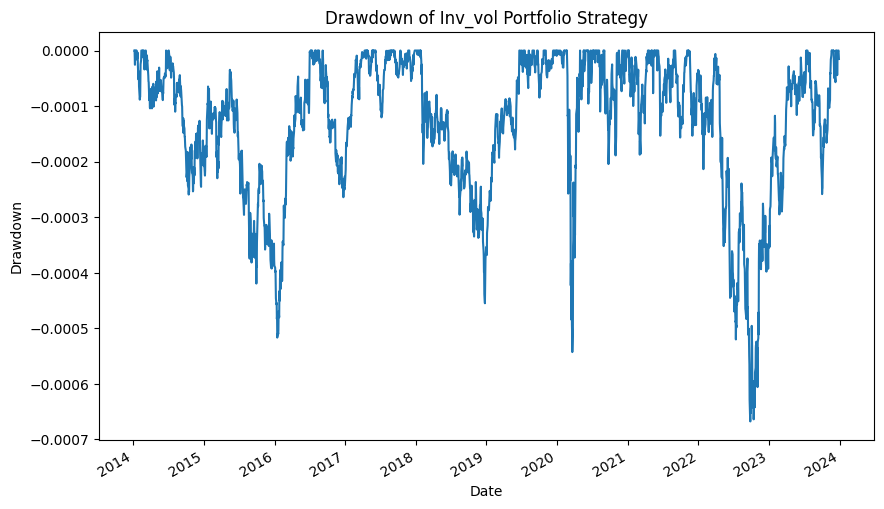

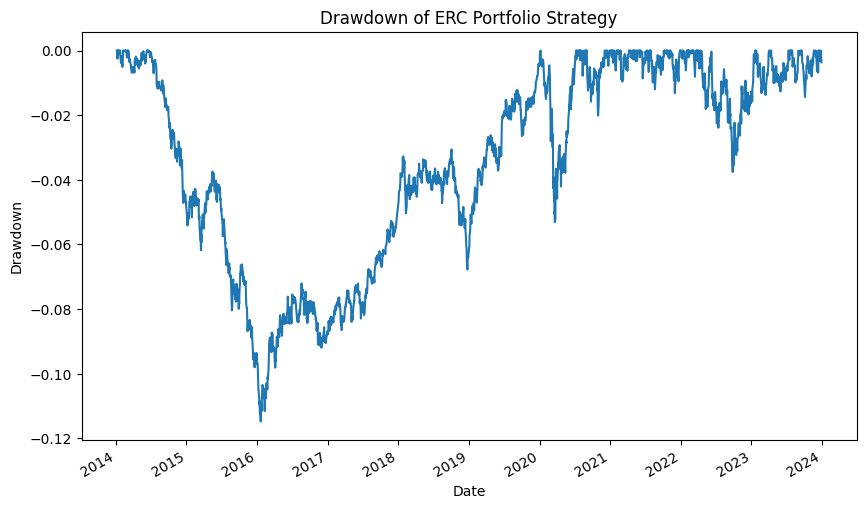

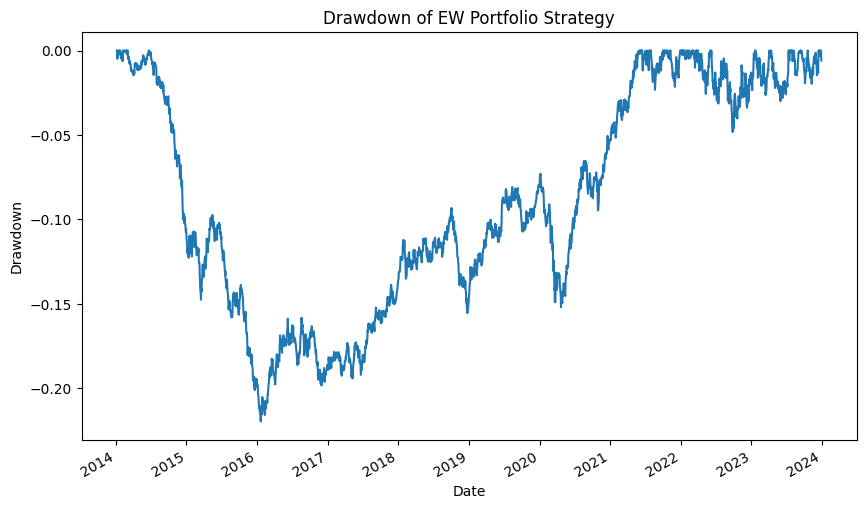

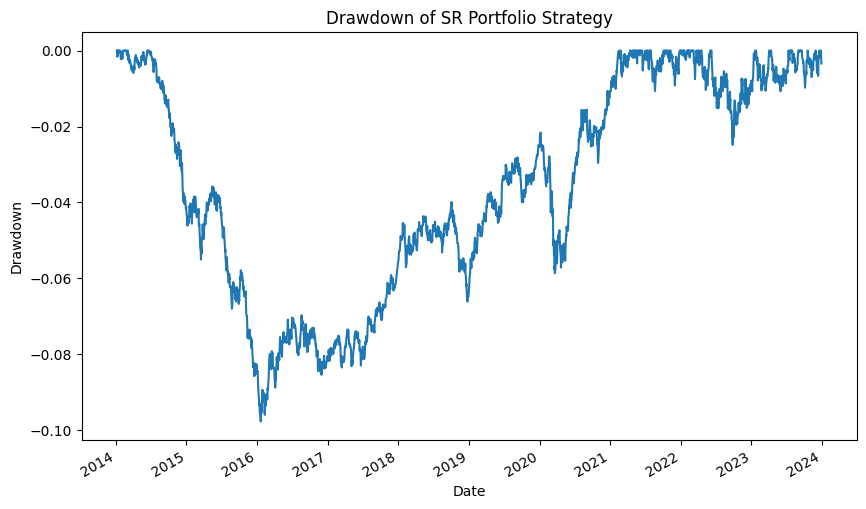

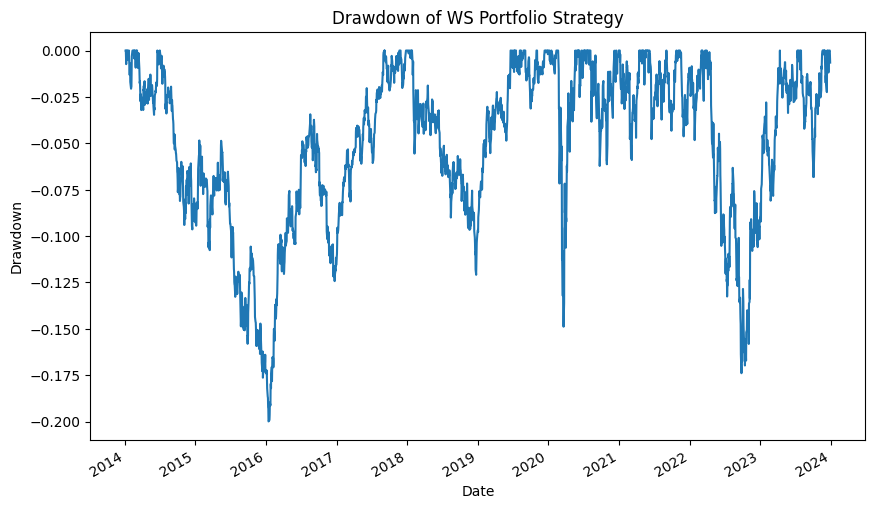

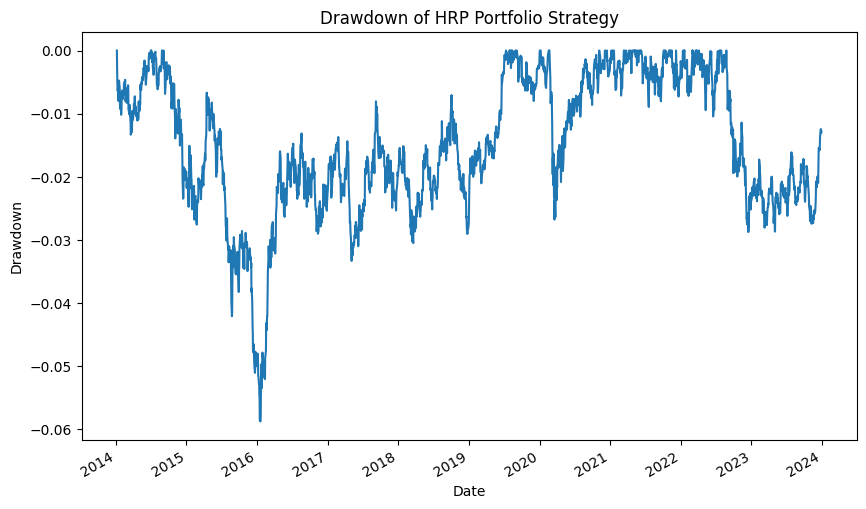

In [201]:
strategies = ['MV', 'Inv_vol', 'ERC', 'EW', 'SR', 'WS', 'HRP']  # List of all strategies

# Loop through each strategy to calculate and plot drawdown
for strategy in strategies:
    # Calculate the cumulative returns
    cumulative_returns = (1 + consolidated_portfolio_returns[strategy]).cumprod()

    # Calculate the drawdown
    drawdown = cumulative_returns.div(cumulative_returns.cummax()).subtract(1)

    # Plot the drawdown
    drawdown.plot(figsize=(10, 6))
    plt.title(f'Drawdown of {strategy} Portfolio Strategy')
    plt.ylabel('Drawdown')
    plt.xlabel('Date')
    plt.show()

In [202]:

# Risk-Reward Scatter Plot
risk_reward_pf = pd.DataFrame({
    'Return': consolidated_portfolio_returns.mean() * 360 * 100,  # Annualize returns
    'Risk': consolidated_portfolio_returns.std() * np.sqrt(360) * 100  # Annualize standard deviation
})
risk_reward_pf.plot(kind='scatter', x='Risk', y='Return', figsize=(10, 6))
plt.title('Risk-Reward Scatter Plot')
plt.xlabel('Annualized Risk (Std. Dev., in %)')
plt.ylabel('Annualized Return (in %)')
for i, txt in enumerate(risk_reward_pf.index):
    plt.annotate(txt, (risk_reward['Risk'][i], risk_reward['Return'][i]))

plt.show()



import plotly.express as px

# Filter out strategies with extreme risk or return values
threshold_risk_upper = risk_reward_pf['Risk'].quantile(0.80)  # 95th percentile as upper threshold
threshold_risk_lower = risk_reward_pf['Risk'].quantile(0.05)  # 5th percentile as lower threshold

# Apply the thresholds to filter out the outliers
filtered_risk_reward_pf = risk_reward_pf[(risk_reward_pf['Risk'] < threshold_risk_upper) & (risk_reward_pf['Risk'] > threshold_risk_lower)]

# Plotting using Plotly for a dynamic plot
fig = px.scatter(filtered_risk_reward_pf, x='Risk', y='Return', text=filtered_risk_reward_pf.index)
fig.update_traces(textposition='top center')
fig.update_layout(
    title='Risk-Reward Scatter Plot',
    xaxis_title='Annualized Risk (Std. Dev., in %)',
    yaxis_title='Annualized Return (in %)',
    showlegend=False
)
fig.show()

We can elaborate more on the behaviour of the different strategies implemented and tehir respective return correlation features.

* Mean Variance (MV) against Inverse Volatility (Inv_vol): With a correlation of 0.81, these two move quite closely. When MV shifts, Inv_vol is likely to be performing similar movements. This indicates that they behave similarly to market movements, making them less suitable for diversification if used together.

* ERC has moderate correlations with other strategies, particularly Inverse Volatility (0.83) and Sharpe Ratio (0.97). This means that ERC's movement is relatively predictable given how these other strategies function.

* Equal Weight (EW) versus Equal Risk Contribution (ERC) has a high correlation (0.91) and moves almost as one. It shows that distributing weights equally or in proportion to risk levels does not significantly alter the portfolio's behaviour.

* Sharpe Ratio (SR) strategy has a near-perfect correlation with Equal Weight (EW) at 0.97, followed by a strong correlation with ERC at 0.95. This shows that aiming for the highest return per unit of risk is directly related to these strategies.

* Wall Street (WS) has, surprisingly, a strong correlation of 0.98 with inverse volatility, implying that Wall Street's discretionary decisions follow a strategy that favours less volatile assets. Interestingly, its correlation with Equal Weight is the lowest, at 0.67, implying some independence from a strategy that ignores market volatility.Its high concentration for gold and equity index trackers (+90% of the allocation) makes it a highly concentrated portfolio.

* Hierarchical Risk Parity (HRP): This strategy stands out for having relatively modest correlations across the board, with the greatest being 0.64 with Equal Weight. Its methodology, which takes into account asset hierarchies and diversification, offers an original approach for portfolio construction.

<Figure size 1600x1200 with 0 Axes>

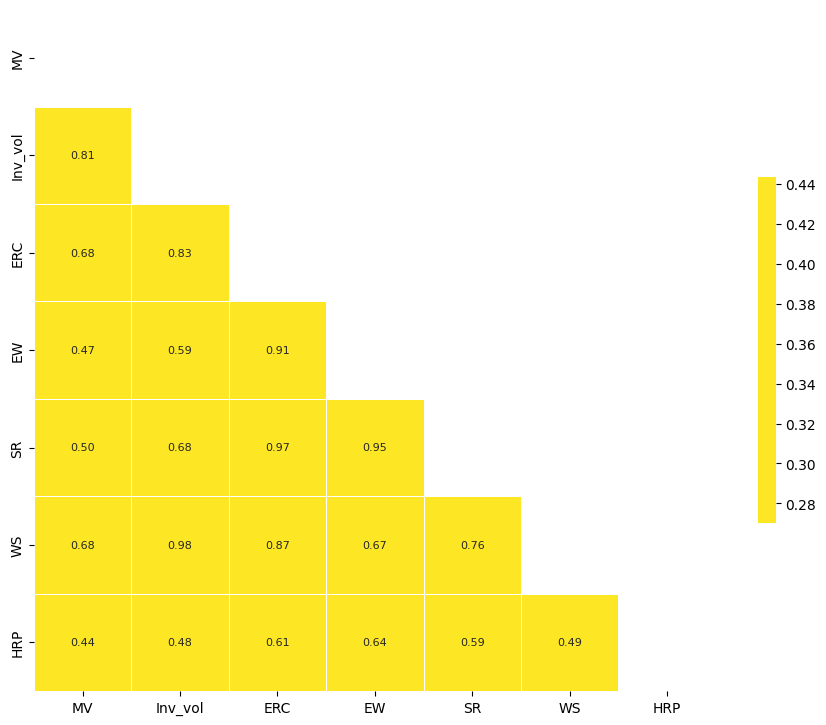

In [203]:
#Correlation of the portfolio strategies tested

correlation_matrix_pf = consolidated_portfolio_returns.corr()

# Using seaborn to create a heatmap of the correlation matrix
# Increase the size of the heatmap.
plt.figure(figsize=(16, 12))

# Generate a mask for the upper triangle.
mask = np.triu(np.ones_like(correlation_matrix_pf, dtype=bool))

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap.
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio.
sns.heatmap(correlation_matrix_pf, mask=mask, cmap='viridis', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of the tick labels for clarity.
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

##  **5. Advanced Portfolio analysis**

The results for the various portfolio strategies reveal a range of outcomes that can inform an investor's strategy alignment with risk tolerance and return expectations. Here's an analysis of the results:

* The Mean-Variance (MV) portfolio has a nominal annualised return and volatility, which means it didn't really earn any extra money over the risk-free rate during the time period that was looked at. We suspect a problem in the implementation part of the strategy.

* The Inverse Volatility portfolio only makes small gains, with an annualised return just above zero and almost no volatility. This could be a sign of a strategy that values security over growth. The higher Sortino ratio shows that this portfolio has handled downside risk better than its peers. This is something that should be looked into more, along with its individual assets and how they were allocated.

* A more balanced method is shown by the Equal Risk Contribution (ERC) strategy, which offers average returns while keeping volatility under control. The negative skewness and excess kurtosis numbers show that the return distribution has avoided sharp tails and, by extension, extreme returns, whether they are positive or negative. We should look into how risk contributions are measured and how they relate to the actual returns because of this finding.

* The Equal Weight (EW) strategy stands out because it has the highest volatility and the biggest maximum loss of all the strategies. However, it also has the highest annualised returns. These results show that risk has two sides: the portfolio has a bigger chance of going up, but it is also very likely to go down when the market goes down.

* Focusing on the Maximum the Sharpe Ratio (SR) strategy, it seems to be a moderately good strategy in terms of returns, but it has less instability than the EW strategy. The strategy's goal to get the best return for the least amount of risk is supported by the negative excess kurtosis, which shows a tendency to avoid extreme results.

* When compared to the other strategies, the Wall-Street (WS) consensus method clearly stands out, with much higher returns that come with a lot of volatility and drawdown. This kind of profile could be seen as an example of a riskier or more aggressive strategy that, while profitable, comes with big risks that could be looked at more closely to see if they can be maintained over longer periods of time. However, some biais related to selection made this portfolio inflate the results. Since there was not splitting of the dataset nor rebalancing of returns in this project, we basically took the best performing assets in the investment universe selected and were heavily exposed to gold and MSCI World which makes it tricky to assume that the discretionary approach would yield similar results out of sample.

* Finally, the Hierarchical Risk Parity (HRP) strategy shows a sensible balance with the lowest possible drawdown, which shows how strong it is when market conditions are bad. This is in line with HRP's objective of building a portfolio that lowers systemic risk by improving understanding of asset correlation and hierarchy.

In [204]:
def calculate_performance_metrics(returns, risk_free_rate):
    # Annualize the risk-free rate (assuming it's provided on an annual basis)
    risk_free_rate_daily = (1 + risk_free_rate) ** (1/252) - 1

    # Initialize a dictionary to store metrics
    metrics = {
        'Annualized Return (%)': returns.mean() * 252,
        'Annualized Volatility (%)': returns.std() * (252 ** 0.5),
        'Skewness': skew(returns),
        'Excess Kurtosis': kurtosis(returns) - 3,
        'Sortino Ratio': None,
        'VaR 95%': None,
        'CVaR 95%': None,
        'Max Drawdown (%)': None
    }

    # Calculate Sortino Ratio
    negative_returns = returns[returns < risk_free_rate_daily]
    downside_std = np.sqrt(np.mean(negative_returns ** 2)) * (252 ** 0.5)
    metrics['Sortino Ratio'] = (metrics['Annualized Return (%)'] - risk_free_rate) / downside_std

    # Calculate VaR 95% and CVaR 95%
    metrics['VaR 95%'] = returns.quantile(0.05)
    metrics['CVaR 95%'] = returns[returns <= metrics['VaR 95%']].mean()

    # Calculate Max Drawdown
    cumulative_returns = (1 + returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / rolling_max - 1
    metrics['Max Drawdown (%)'] = drawdown.min()

    # Convert metrics to percentages where appropriate
    for metric in ['Annualized Return (%)', 'Annualized Volatility (%)', 'Max Drawdown (%)']:
        metrics[metric] = metrics[metric] * 100

    # Format the results for better readability
    formatted_metrics = {k: f"{v:.2f}" for k, v in metrics.items() if isinstance(v, float)}
    formatted_metrics['Skewness'] = f"{metrics['Skewness']:.3f}"
    formatted_metrics['Excess Kurtosis'] = f"{metrics['Excess Kurtosis']:.3f}"
    formatted_metrics['Sortino Ratio'] = f"{metrics['Sortino Ratio']:.3f}"
    formatted_metrics['VaR 95%'] = f"{metrics['VaR 95%']:.3f}"
    formatted_metrics['CVaR 95%'] = f"{metrics['CVaR 95%']:.3f}"

    return pd.Series(formatted_metrics)

# Calculate the performance metrics for each strategy
risk_free_rate_annual = 0.00
strategy_metrics_df = consolidated_portfolio_returns.apply(
    calculate_performance_metrics, risk_free_rate=risk_free_rate_annual)

# Display the formatted performance metrics
strategy_metrics_df.T

,Annualized Return (%),Annualized Volatility (%),Skewness,Excess Kurtosis,Sortino Ratio,VaR 95%,CVaR 95%,Max Drawdown (%)
MV,0.00,0.00,-0.312,0.881,0.505,-0.000,-0.000,-0.01
Inv_vol,0.02,0.04,-0.100,1.283,0.652,-0.000,-0.000,-0.07
ERC,1.72,3.10,-0.198,-1.940,0.541,-0.003,-0.004,-11.48
EW,1.63,5.14,-0.038,-3.238,0.317,-0.005,-0.006,-21.97
SR,1.03,2.25,-0.129,-3.023,0.450,-0.002,-0.003,-9.76
WS,6.80,10.45,-0.101,0.552,0.642,-0.010,-0.015,-19.99
HRP,0.45,2.26,-0.127,-1.669,0.194,-0.002,-0.003,-5.88


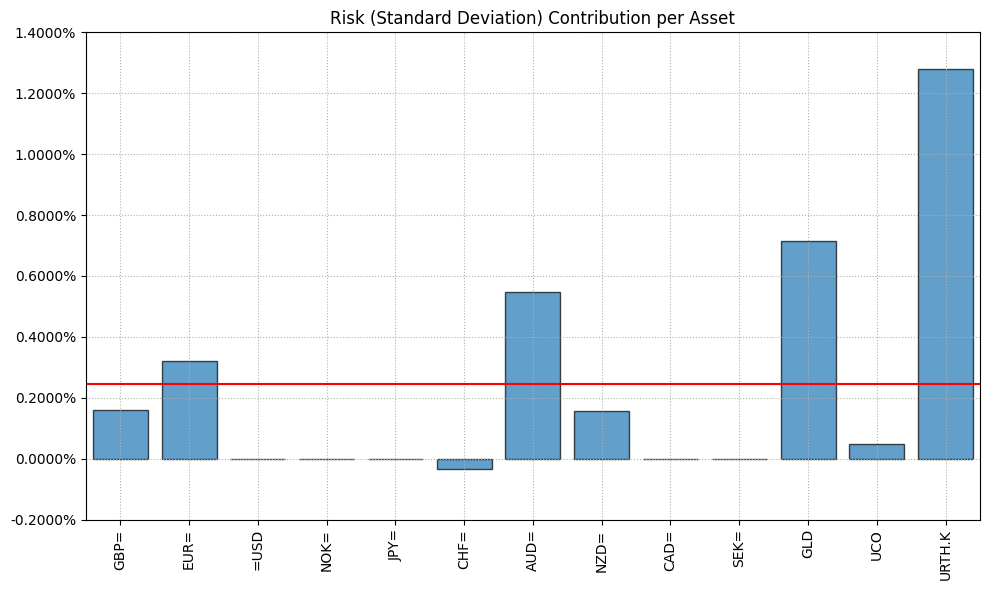

In [205]:
# Plotting the risk composition of the Minimum Variance (MV) portfolio

ax_sharpeMV_risk = rp.plot_risk_con(w_MV, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

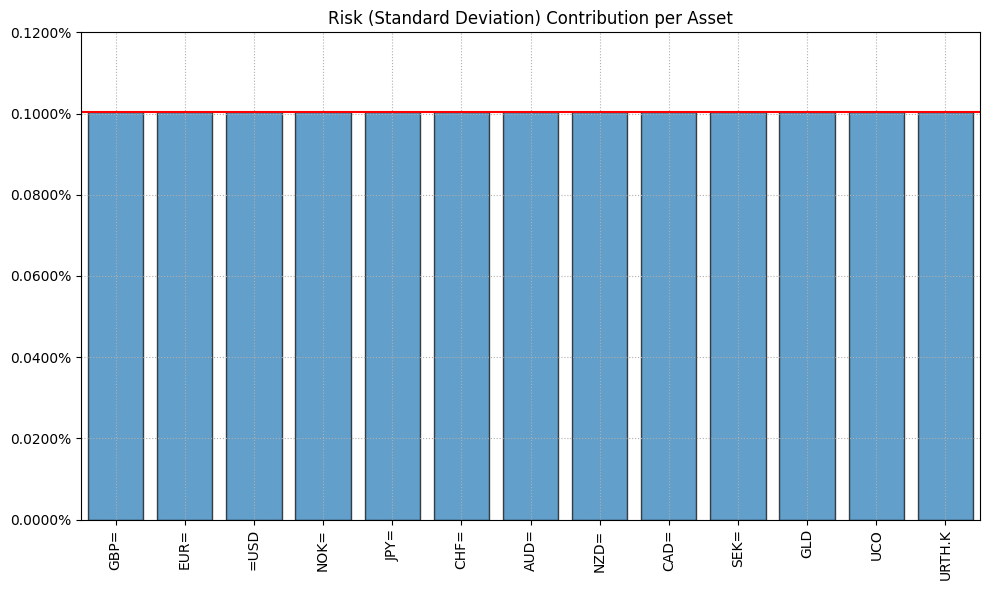

In [206]:
#Risk contribution of Risk Parity (ERC) portfolio
ax_RiskParity_Variance_risk= rp.plot_risk_con(w_ERC, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

In the context of the HRP, assets are grouped hierarchically using statistical methods, which typically entails measuring the distances between historical asset returns. In this instance, the dendrogram show an asset clustering constructed on the following six asset clusters:


* Cluster 1: NZD=, AUD=, GBP=, EUR=
* Cluster 2: UCO, CAD=, URTH.K
* Cluster 3: NOK=, SEK=, =USD, CHF=
* Cluster 4: JPY=, GLD

It is possible to achieve diversification by looking at the groups and figuring out which assets can be put together. To spread risk, the portfolio should have at least one item from each group. A group of assets with a positive relative correlation is shown by the bright block on the graph. In other words, they are likely to move in the same way if the market stays the same. To get better risk-adjusted returns, it is important to balance these groups with assets from other groups that don't have strong ties. The HRP doesn't just put the assets into groups; it also gives them weights that are the opposite of how risky they are. Its purpose is to make sure that each group shares the portfolio's risk evenly. Some assets show low correlation. These assets can help lower the risk of a portfolio. One example is if a main commodity, like gold (GLD), has a negative correlation with equities, it might work as a cushion if the market goes down.

/usr/local/lib/python3.10/dist-packages/riskfolio/src/PlotFunctions.py:2872: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



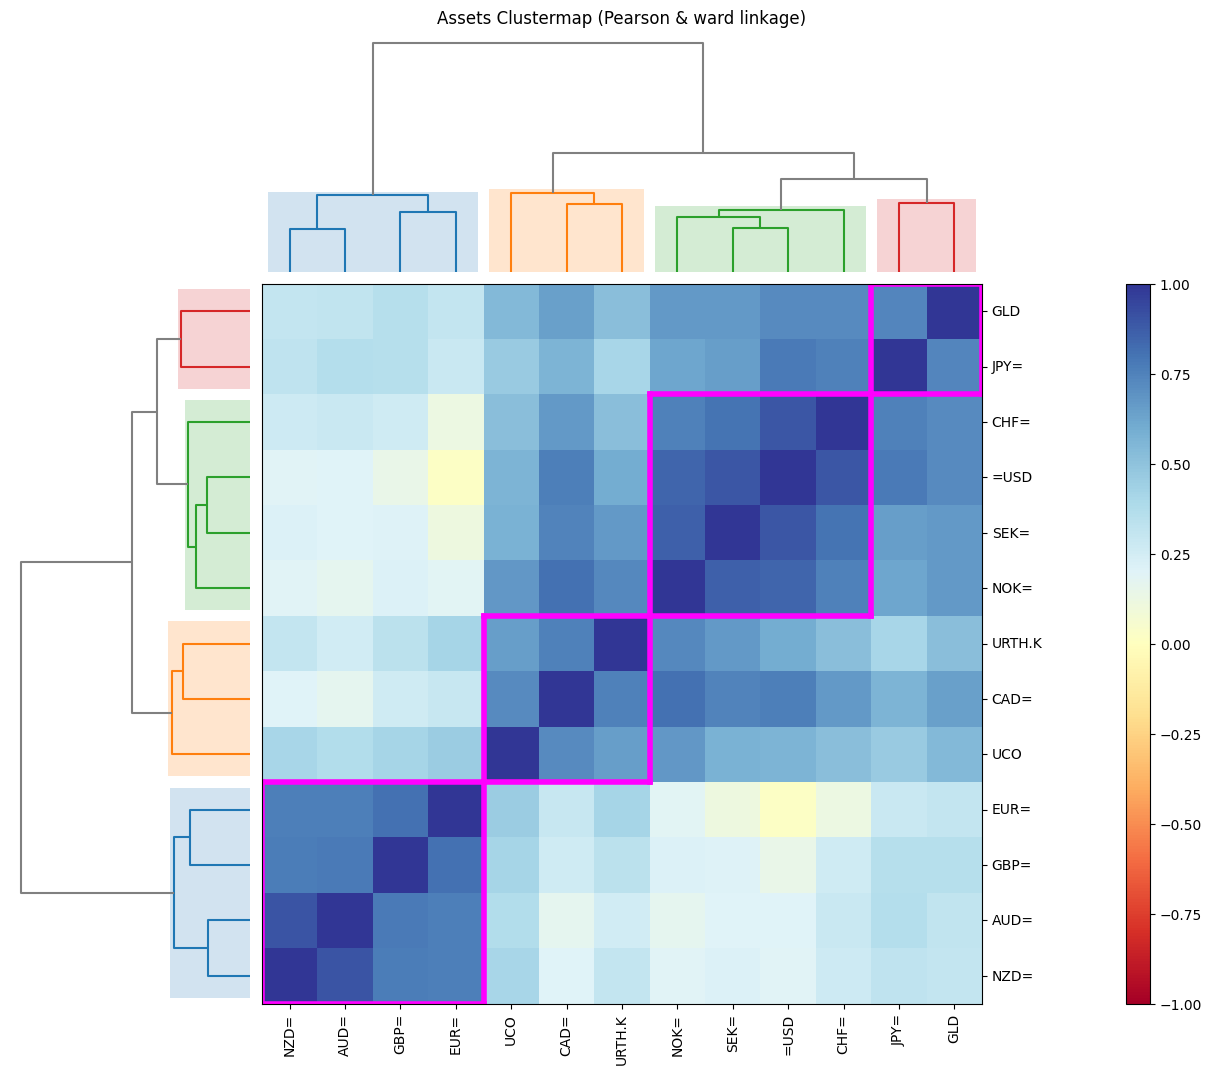

In [207]:
# Plotting assets clusters for Hirarchical Risk Parity (HRP) portfolio construction

ax_HRP_clustering= rp.plot_clusters(returns=arith_returns_scaled,
                      codependence='pearson',
                      linkage='ward',
                      k=None,
                      max_k=10,
                      leaf_order=True,
                      dendrogram=True,
                      #linecolor='tab:purple',
                      ax=None)

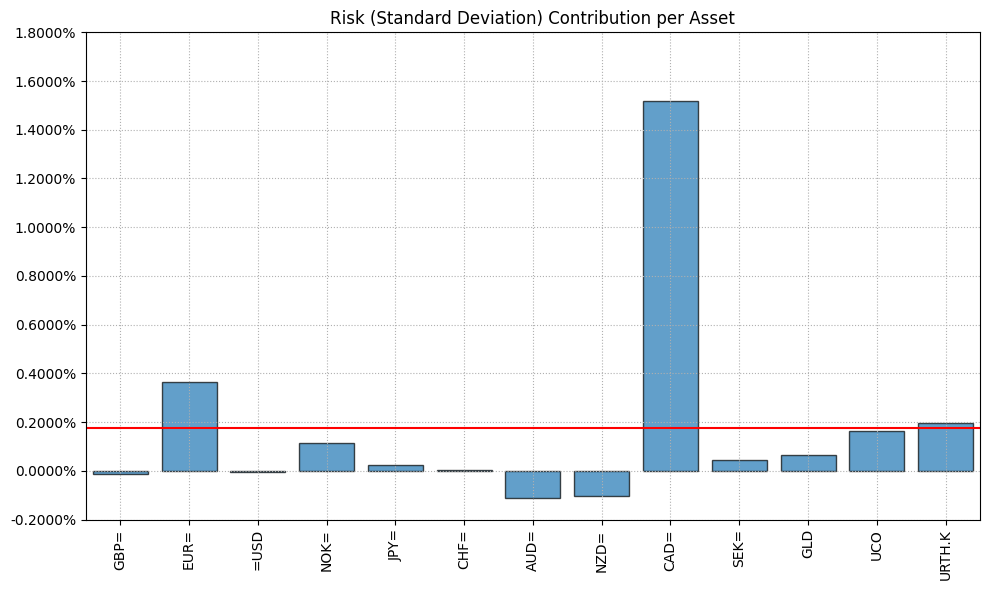

In [208]:
# Plotting the risk contribution of Hierarchical Risk Parity (HRP) portfolio per asset

mu = arith_returns_scaled.mean()
cov = arith_returns_scaled.cov() # Covariance matrix
returns = arith_returns_scaled # Returns of the assets

ax_HRP_clustering_risk = rp.plot_risk_con(w=w_HRP,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

**Summary of the results**

* The Mean-Variance (MV) portfolio's performance is the same as the risk-free rate, which means there may be problems with how it was put together and needs to be looked at again.

* The Inverse Volatility portfolio has small gains with little volatility, which suggests a conservative strategy that handles downside risks better than its peers. Its allocation choices should be looked at more closely.

* With its return distribution avoiding extremes, Equal Risk Contribution (ERC) exhibits moderate volatility and controlled returns, suggesting the need to look into the connection between measured risk contributions and realised returns.

* Equal Weight (EW) has high returns but also big downsides and volatility. This is because risk has two sides: it can lead to big growth but can also make you vulnerable to market downturns.

* The Maximum Sharpe Ratio (SR) optimised strategy has average returns and low volatility. Its negative extra kurtosis shows that it avoids extreme outcomes, which is in line with its goal of maximising risk-adjusted returns.

* The Wall-Street (WS) consensus shows very high returns, but also more volatility and drawdowns. This suggests a strategy that might be risky or aggressive, with a lot of risks built in. Its biassed towards high-performing assets like gold and MSCI World and the fact that it doesn't split or rebalance its data suggest that its results may not be very useful when used outside of the sample.

* Hierarchical Risk Parity (HRP) is the most resilient during downturns, as shown by its lowest drawdowns. This is in line with its strategy of reducing systemic risk through a complex approach to asset correlation and hierarchy.

The performance insights for each strategy stress how important it is to think critically about the methods used and the market conditions in order to understand how results can be sustained and repeated.

## **Conclusion**

The project's conclusion covers several crucial features of the analysed portfolio management strategies, which must be examined for a thorough comprehension.

First, the results are based only on a buy-and-hold strategy. This indicates that there was no rebalancing or data splitting during the investment period. Optimal weights were calculated at the start and maintained throughout the analysis period. As a result, the reported performance reflects the hypothetical scenario in which an investor keeps the beginning allocation constant for the whole time. This methodological decision has substantial repercussions.

It ignores the potential advantages of rebalancing, which, in fact, can account for market movements and asset correlations that alter over time. Rebalancing could potentially lower risk while increasing returns by capitalising on the reversion to mean across assets.

The buy-and-hold strategy also implies that the initial conditions and investor expectations remain consistent across the investing horizon, which is rarely true in dynamic markets.

Second, the study fails to account for transaction costs. In practice, these fees can have a significant impact on overall performance, particularly in strategies that involve frequent trades. By excluding transaction expenses, the project likely displays a more favourable performance situation than what would be encountered in practical deployments.

Third, no leverage restrictions are imposed to the strategies; instead, they are all constrained by equal weight constraints that amount to one. This constraint means a simpler risk profile, with no opportunity to leverage prospective returns with borrowed cash. While this may indicate a conservative investment attitude, it also implies that the strategies' ability to generate returns is not fully examined.

The Wall Street portfolio, in particular, stands out due to its focus on two assets that have done well within the chosen investing universe: gold and the MSCI World Index. This concentration raises concerns about the diversification and feasibility of this strategy in a realistic scenario. Despite the apparent benefit in performance indicators, a concentrated portfolio may be at higher risk due to a lack of diversification. Related to feasibility, the Wall Street portfolio's performance may not be reproducible because it is highly reliant on previous performance of these two assets, which may not continue in the future.

Finally, the benchmark's simplicity in comparison to the Sortino ratio is highlighted. Except for Hierarchical Risk Parity (HRP), all strategies had greater Sortino ratios than Equal Weight, signifying better risk-adjusted performance. The HRP's lower Sortino ratio could be seen as a trade-off for smaller drawdown and thus stronger resilience during market downturns.

In conclusion, while the reported results indicate that these strategies may surpass a simple benchmark, one must recognise the constraints and assumptions underlying the research. The absence of transaction costs, the lack of rebalancing, and the use of a basic benchmark may overestimate the strategies' efficacy. Furthermore, the Wall Street portfolio's lack of leverage and concentrated asset allocation underline the importance of exercising caution when interpreting the outcomes. In practice, a more comprehensive method that takes these elements into account could provide a more accurate picture of each strategy's prospective performance.

*Academic references*

- De Prado (2016). *Building Diversified Portfolios that Outperform Out-of-Sample*. Journal of Portfolio Management; https://doi.org/10.3905/jpm.2016.42.4.059. , Available at SSRN: https://ssrn.com/abstract=2708678 or http://dx.doi.org/10.2139/ssrn.2708678.
- De Prado (2016). *Building Diversified Portfolios That Outperform Out-of-Sample* (Presentation Slides), (January 10, 2016). Available at SSRN: https://ssrn.com/abstract=2713516 or http://dx.doi.org/10.2139/ssrn.2713516
- Roncalli, Thierry, Introduction to Risk Parity and Budgeting (June 1, 2013). Roncalli T. (2013), Introduction to Risk Parity and Budgeting, Chapman & Hall/CRC Financial Mathematics Series, Available at SSRN: https://ssrn.com/abstract=2272973 or http://dx.doi.org/10.2139/ssrn.2272973.

*Business analysis*

**JPMorgan Asset Management (JPM AM)**

- Global Macro Outlook 2023-2024: https://am.jpmorgan.com/us/en/asset-management/adv/insights/market-insights/investment-outlook/

**Goldman Sachs Asset Management (GS AM)**

- Global Investment Strategy 2023: https://www.gsam.com/content/gsam/us/en/advisors/market-insights/market-strategy/outlook/2023/investment-ideas-2023-coming-up-for-air.html

**BlackRock**

- Global Allocation Insights 2023: https://www.blackrock.com/us/individual/insights/blackrock-investment-institute/outlook
